<a href="https://colab.research.google.com/github/NatP-dev/Case_06/blob/main/daily_interest_rates_data_analysis_23062025_0911.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Daily Interest Rates**

#### **Authors**: Group 7
- Nathalia Pouroullis
- Egon Soontiëns
- Isa Widdershoven
- Max Thönissen


In [2]:
# #------------------------------EXPORT AS HTML-----------------#
# !jupyter nbconvert --to html /content/Daily_Interest_Rates_Data_Analysis_02062025_0817.ipynb

## **<font color='#474747'>0 - Imports**</font>



In [3]:
################################ LIBRARIES ########################
# -------------------------- Core Libraries -------------------------- #
import os
import pandas as pd
import re
from IPython.display import display
import numpy as np


# -------------------------- Plotting -------------------------- #
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.stats import zscore
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, Easter, GoodFriday, EasterMonday
from datetime import date, timedelta
from dateutil.easter import easter


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



---
---
<br><br>
# **<font color='#000058'>Chapter 1: Data Quality Assessment</font>**



## **<font color='#474747'>1.1 - Load All Data Files**

In [4]:
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Step 2: Set the path to your folder containing the 31 CSV files
# Replace this path with the actual folder path inside your Drive
folder_path = '/content/drive/MyDrive/EMAS 14 Case 6/Data/Interest Rates/Daily'


In [6]:
# Step 3: Load all CSV files into a list of DataFrames
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Optional: Sort filenames to maintain a consistent order
csv_files.sort()

In [7]:
# Step 4: Read all CSV files
dataframes = []
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes.append(df)

# Now `dataframes` is a list of 31 DataFrames (one per CSV)
# Example: access the first DataFrame
print(dataframes[0].head())

          Unnamed: 0 BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A  \
0                NaN  Term structure of interest rates on listed Fed...      
1            Comment  Monatsendstandsreihe: WZ9807. Bis Juli 1997 li...      
2           Decimals                                                  2      
3   Time format code                                                P1D      
4  Unit (in english)                                            percent      

  BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A_FLAGS  
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           


In [8]:
# Loop for files into their own dataframes
for i in range(len(dataframes)):
    print(f"DataFrame {i}: {csv_files[i]}")

DataFrame 0: daily-term-structure-spot-interest-rate-R005X.csv
DataFrame 1: daily-term-structure-spot-interest-rate-R01XX.csv
DataFrame 2: daily-term-structure-spot-interest-rate-R02XX.csv
DataFrame 3: daily-term-structure-spot-interest-rate-R03XX.csv
DataFrame 4: daily-term-structure-spot-interest-rate-R04XX.csv
DataFrame 5: daily-term-structure-spot-interest-rate-R05XX.csv
DataFrame 6: daily-term-structure-spot-interest-rate-R06XX.csv
DataFrame 7: daily-term-structure-spot-interest-rate-R07XX.csv
DataFrame 8: daily-term-structure-spot-interest-rate-R08XX.csv
DataFrame 9: daily-term-structure-spot-interest-rate-R09XX.csv
DataFrame 10: daily-term-structure-spot-interest-rate-R10XX.csv
DataFrame 11: daily-term-structure-spot-interest-rate-R11XX.csv
DataFrame 12: daily-term-structure-spot-interest-rate-R12XX.csv
DataFrame 13: daily-term-structure-spot-interest-rate-R13XX.csv
DataFrame 14: daily-term-structure-spot-interest-rate-R14XX.csv
DataFrame 15: daily-term-structure-spot-interest-r

Note:

All 31 interest rate CSV files were successfully loaded into individual pandas DataFrames. File sorting ensures consistency in maturity order, which is important for structured time series analysis.

### **<font color='#474747'>*1.1 - Format Dataframes Consistently*</font>**
What was done to format the files:
1. Start at row 11
2. Have no headers
3. Rename columns:
  * Column 1: Date (convert to datetime)
  * Column 2: Value (float, 2 decimals)
  * Column 3: Info message like "No value available"
4. Add a new column FileReferenceName with the filename.



In [23]:
# Step 5: Read all CSVs from row 11 onward, format consistently
dataframes = []

for file in csv_files:
    full_path = os.path.join(folder_path, file)

    df = pd.read_csv(full_path, skiprows=10, header=None, dtype=str, encoding='utf-8')
    df.columns = ["Date", "Interest Rate", "Information No IR"]

    # Clean and parse columns
    df["Date"] = df["Date"].str.strip()
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
    df["Interest Rate"] = pd.to_numeric(df["Interest Rate"], errors="coerce")
    df["FileReferenceName"] = file

    dataframes.append(df)

# Adjust maturity assignment, with special handling for R005X
for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]

    if "R005X" in file_name:
        df["Maturity"] = 0.5
    else:
        match = re.search(r"R(\d{2})X", file_name)
        if match:
            df["Maturity"] = int(match.group(1))  # e.g., R01XX → 1
        else:
            df["Maturity"] = None  # fallback


In [10]:
# CHECK DATA MANUALLY (Ensure alignment with excels)
# Head
display(dataframes[0].head(5))

# Tail
display(dataframes[0].tail(5))

,Date,Interest Rate,Information No IR,FileReferenceName,Maturity
0,1997-08-01,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
1,1997-08-02,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
2,1997-08-03,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
3,1997-08-04,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
4,1997-08-05,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5


,Date,Interest Rate,Information No IR,FileReferenceName,Maturity
10145,2025-05-11,NaN,No value available,daily-term-structure-spot-interest-rate-R005X.csv,0.5
10146,2025-05-12,1.93,NaN,daily-term-structure-spot-interest-rate-R005X.csv,0.5
10147,2025-05-13,1.95,NaN,daily-term-structure-spot-interest-rate-R005X.csv,0.5
10148,2025-05-14,1.94,NaN,daily-term-structure-spot-interest-rate-R005X.csv,0.5
10149,2025-05-15,1.93,NaN,daily-term-structure-spot-interest-rate-R005X.csv,0.5


Note:

A uniform formatting approach was applied to all files by skipping the metadata header, assigning column names (Date, Interest Rate, and Information No IR), and extracting maturity information from the filename. Special care was taken to properly format dates and convert numeric values, ensuring compatibility for downstream analysis.

## **<font color='#474747'>1.2 - Data Pre-processing**

###### **1.2.5.3 - Interpolation Use Case**

In [11]:
# --------------------- MISSING BLOCK SUMMARY (All Gaps for Selected File) ---------------------
import pandas as pd
import numpy as np
from datetime import date, timedelta
from dateutil.easter import easter

# --- Reuse the holiday function from earlier ---
def get_excel_holidays(year):
    from datetime import date
    e = easter(year)
    return set([
        date(year, 1, 1),
        e - timedelta(days=2),
        e + timedelta(days=1),
        date(year, 5, 1),
        date(year, 12, 24),
        date(year, 12, 25),
        date(year, 12, 26),
        date(year, 12, 31),
    ])

# Recompute holiday list
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year
all_holidays = set()
for y in range(min_year, max_year + 1):
    all_holidays.update(get_excel_holidays(y))
holiday_dates = pd.to_datetime(list(all_holidays))


# ------------------------------------------------------------- CHANGE THIS TO SELECT A DIFFERENT FILE ------------------------------------------#
# --- Select which dataframe to use ---
selected_df_index = 13  # CHANGE THIS TO SELECT A DIFFERENT FILE
# -----------------------------------------------------------------------------------------------------------------------------------------------#
df = dataframes[selected_df_index].copy()

# Filter
df = df[df["Date"].notnull()].copy()
df = df[~df["Date"].dt.weekday.isin([5, 6])]
df = df[~df["Date"].isin(holiday_dates)]

# Build full business date range and reindex
full_dates = pd.date_range(start=df["Date"].min(), end=df["Date"].max(), freq="B")
full_dates = full_dates[~full_dates.isin(holiday_dates)]
df = df.set_index("Date").sort_index()
df = df.reindex(full_dates)
df.reset_index(inplace=True)
df.rename(columns={"index": "Date"}, inplace=True)

# Identify missing blocks
df["Missing"] = df["Interest Rate"].isna().astype(int)
df["Gap_ID"] = (df["Missing"].diff(1) == 1).cumsum() * df["Missing"]

# Group and summarize missing blocks
block_summary = []

missing_blocks = df[df["Missing"] == 1].groupby("Gap_ID")

for gid, group in missing_blocks:
    start_date = group["Date"].iloc[0]
    end_date = group["Date"].iloc[-1]

    # Only count valid business days excluding holidays
    expected_range = pd.date_range(start=start_date, end=end_date, freq="B")
    expected_range = expected_range[~expected_range.isin(holiday_dates)]
    missing_days = len(expected_range)

    idx_before = df[df["Date"] < start_date]["Interest Rate"].last_valid_index()
    value_before = df.loc[idx_before, "Interest Rate"] if idx_before is not None else None
    date_before = df.loc[idx_before, "Date"] if idx_before is not None else None

    idx_after = df[df["Date"] > end_date]["Interest Rate"].first_valid_index()
    value_after = df.loc[idx_after, "Interest Rate"] if idx_after is not None else None
    date_after = df.loc[idx_after, "Date"] if idx_after is not None else None

    block_summary.append({
        "Gap Start": start_date.date(),
        "Gap End": end_date.date(),
        "Missing Business Days": missing_days,
        "Last Known Date": date_before.date() if pd.notnull(date_before) else None,
        "Last Known Value": round(value_before, 4) if pd.notnull(value_before) else None,
        "Next Known Date": date_after.date() if pd.notnull(date_after) else None,
        "Next Known Value": round(value_after, 4) if pd.notnull(value_after) else None
    })


# Create and show table
gap_df = pd.DataFrame(block_summary)
print(f"Missing Gaps for File Index {selected_df_index} (Maturity = {df['Maturity'].dropna().iloc[0]}):")
display(gap_df)


Missing Gaps for File Index 13 (Maturity = 13):


,Gap Start,Gap End,Missing Business Days,Last Known Date,Last Known Value,Next Known Date,Next Known Value
0,1997-08-04,1997-08-06,3,None,NaN,1997-08-07,6.25
1,1997-10-03,1997-10-03,1,1997-10-02,5.91,1997-10-06,5.84
2,1998-05-21,1998-05-21,1,1998-05-20,5.36,1998-05-22,5.23
3,1998-06-01,1998-06-01,1,1998-05-29,5.24,1998-06-02,5.13
4,1998-06-11,1998-06-11,1,1998-06-10,5.13,1998-06-12,5.09
5,1999-05-13,1999-05-13,1,1999-05-12,4.69,1999-05-14,4.58
6,1999-05-24,1999-05-24,1,1999-05-21,4.62,1999-05-25,4.58
7,1999-06-03,1999-06-03,1,1999-06-02,4.84,1999-06-04,4.86
8,2000-10-03,2000-10-03,1,2000-10-02,5.39,2000-10-04,5.43
9,2007-05-28,2007-05-28,1,2007-05-25,4.47,2007-05-29,4.48


Note:

The block summary analysis provides a maturity-specific deep dive into where gaps exist and what values are used for interpolation. Most gaps are small (1–3 days) and flanked by valid data, supporting linear interpolation. Some early gaps (e.g., first 6 business days) likely reflect initial reporting lags rather than market absences. These early gaps are excluded from model calibration, as interpolating them could bias the short end of the curve — particularly relevant for forward rate extraction or regulatory applications.

<br><br>
Research on what caused this missing data:
Daily interest rate data from the Bundesbank begins in August 1997, but no rates are published between August 1st and 6th. The first available daily value is dated August 7th, reflecting a transitional implementation phase from monthly to daily curve publication. This could be the reason behind this constant missing data.
<br><br>
Research on Interpolation Methods:
Linear interpolation is used as gaps and interest rate jumps are not extreme enough ,where there is 1-3 days of misisng interets rates, to justify using another method such as spline.

## **<font color='#474747'>1.3 - Data Cleaning**
* Check:
- Public holidays
- Rules

### **<font color='#474747'>*1.3.1 - Apply Data Cleaning*</font>**
* Remove weekends completely
* Remove public holidays
*  Forward-fill missing values (only on weekdays)
* Interpoalte remaning gaps because for yield curve modeling (e.g., Nelson-Siegel) - continuity is needed.

In [12]:
print("#-------------------------------------   DATA CLEANING - Apply Filling  -------------------------------------#")
#--------------------- STEP 1: REMOVE WEEKENDS AND PUBLIC HOLIDAYS ---------------------#
from datetime import date, timedelta
from dateutil.easter import easter

# Define Excel-style public holiday function
def get_excel_holidays(year):
    e = easter(year)
    return set([
        date(year, 1, 1),           # New Year's Day
        e - timedelta(days=2),      # Good Friday
        e + timedelta(days=1),      # Easter Monday
        date(year, 5, 1),           # Labour Day
        date(year, 12, 24),         # Christmas Eve
        date(year, 12, 25),         # Christmas Day
        date(year, 12, 26),         # Boxing Day
        date(year, 12, 31),         # New Year's Eve
    ])

# Compute full holiday list across all years in the dataset
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year

holiday_set = set()
for y in range(min_year, max_year + 1):
    holiday_set.update(get_excel_holidays(y))

holiday_dates = pd.to_datetime(list(holiday_set))

# Clean each DataFrame: remove weekends and public holidays
for i in range(len(dataframes)):
    df = dataframes[i]

    # Remove invalid or null dates
    df = df[df["Date"].notnull()].copy()

    # Exclude weekends
    df = df[~df["Date"].dt.weekday.isin([5, 6])]

    # Exclude public holidays
    df = df[~df["Date"].isin(holiday_dates)]

    # Update in list
    dataframes[i] = df

print(f"Step 1 Complete: Removed weekends and public holidays from all {len(dataframes)} files.")

#--------------------- STEP 2: INTERPOLATE REMAINING GAPS USING LINEAR METHOD ---------------------#

for i in range(len(dataframes)):
    df = dataframes[i].copy()

    # Interpolate missing Interest Rate values using time-indexed linear interpolation
    df["Interest Rate"] = df["Interest Rate"].interpolate(method="linear")

    # Save back to list
    dataframes[i] = df

print("Step 3 Complete: Remaining missing values interpolated using linear method.")


#-------------------------------------   DATA CLEANING - Apply Filling  -------------------------------------#
Step 1 Complete: Removed weekends and public holidays from all 31 files.
Step 3 Complete: Remaining missing values interpolated using linear method.


Note:

We observe systematic missing data in the first 3-4 business days of several interest rate time series. As this may be due to initialization lag in the source system, and not true market absence, we exclude these initial values from model calibration. This ensures our estimation of the short end of the yield curve is not biased by interpolated artefacts. The cleaned dataset starts from the first valid observation per maturity.

* Solvency II compliance requires transparency and justification of data treatments, especially interpolation or imputation steps.

* Long horizons (up to 80 years) and model sensitivity to initial values means early missingness can meaningfully affect model calibration

---
---
<br><br>
# **<font color='#000058'>Chapter 2: Statistical Properties</font>**


In [13]:
# ------------------ IMPORTS ------------------#
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.tsa.stattools import ccf
import numpy as np

## **<font color='#474747'>2.1 - Summary Statistics (Interest Rates)**

In [37]:
# Assumes `dataframes` contains the cleaned datasets with columns:
# ------------------ SUMMARY STATS ------------------#
summary_stats = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    clean_df = df.dropna(subset=["Interest Rate"])
    summary_stats.append({
        "Maturity": maturity,
        "Count": clean_df["Interest Rate"].count(),
        "Mean": clean_df["Interest Rate"].mean(),
        "Median": clean_df["Interest Rate"].median(),
        "Std": clean_df["Interest Rate"].std(),
        "Min": clean_df["Interest Rate"].min(),
        "Max": clean_df["Interest Rate"].max()
    })

stats_df = pd.DataFrame(summary_stats).set_index("Maturity").sort_index()
display(stats_df)

,Count,Mean,Median,Std,Min,Max
Maturity,,,,,,
0.5,7048,1.520241,1.655,1.833644,-0.98,5.12
1.0,7048,1.564343,1.805,1.842042,-0.97,5.23
2.0,7048,1.661152,1.890,1.863627,-1.02,5.32
3.0,7048,1.781524,1.990,1.885157,-1.02,5.33
4.0,7048,1.914735,2.170,1.900096,-1.00,5.35
5.0,7048,2.051073,2.320,1.907814,-0.98,5.42
6.0,7048,2.184051,2.430,1.909892,-0.95,5.48
7.0,7048,2.309895,2.480,1.908469,-0.93,5.61
8.0,7048,2.426436,2.550,1.905424,-0.91,5.73



### **<font color='#474747'>*2.3.2. - PCA on Level IRs*</font>**

In [51]:
# ----------------- Merge Cleaned DataFrames into Wide Format -----------------

merged_df = pd.DataFrame()
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[["Date", "Interest Rate"]].copy()
    temp = temp.rename(columns={"Interest Rate": f"M{maturity}"})
    merged_df = temp if merged_df.empty else pd.merge(merged_df, temp, on="Date", how="outer")

final_df = merged_df


###### **2.3.2.a -  t-Copula (Pre PCA Check)**


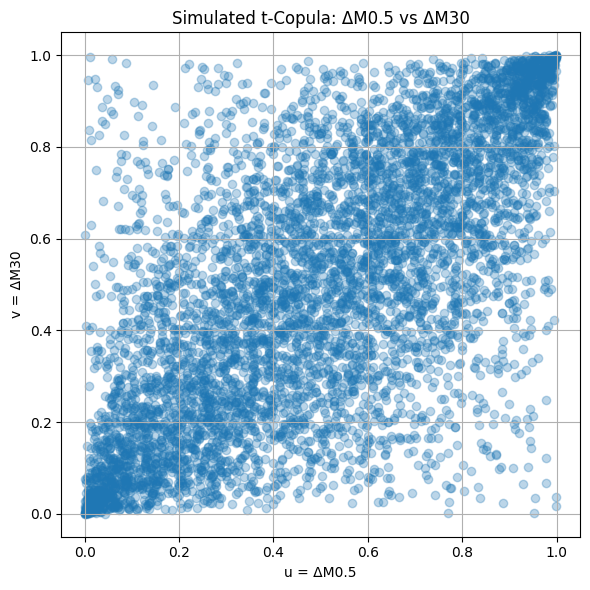

In [26]:
# --------------------- Manual t-Copula Fitting --------------------- #
import numpy as np
from scipy.stats import t
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# Step 1: Prepare pseudo-uniform margins
U = merged_df.drop(columns="Date").dropna()
U_ranks = U.rank(axis=0, method="average")
U_uniform = U_ranks.divide(len(U_ranks) + 1)  # pseudo-uniform margins

# Step 2: Inverse-t transform → t-distributed scores
df_t = 4  # degrees of freedom
Z = t.ppf(U_uniform, df=df_t)  # shape (n_obs, n_maturities)

# Step 3: Empirical correlation on t-scores
Sigma_hat = np.corrcoef(Z.T)

# Step 4: Simulate multivariate t via Cholesky
n_sim, k = Z.shape
L = cholesky(Sigma_hat, lower=True)

# draw standard normals, then impose correlation
Z_sim = np.random.standard_normal((n_sim, k)) @ L.T

# draw chi² and reshape for broadcasting
chi2_samples = np.random.chisquare(df_t, size=n_sim)  # shape (n_sim,)

# map normals→t by dividing by sqrt(χ²/df)
T_sim = Z_sim / np.sqrt( (chi2_samples[:, None] / df_t) )

# Step 5: back to [0,1] via t CDF
U_sim = t.cdf(T_sim, df=df_t)

# --------------------- Plot t-Copula Dependence --------------------- #
i, j = 0, -1  # e.g. shortest vs. longest maturity
plt.figure(figsize=(6, 6))
plt.scatter(U_sim[:, i], U_sim[:, j], alpha=0.3)
plt.title(f"Simulated t-Copula: Δ{U.columns[i]} vs Δ{U.columns[j]}")
plt.xlabel(f"u = Δ{U.columns[i]}")
plt.ylabel(f"v = Δ{U.columns[j]}")
plt.grid(True)
plt.tight_layout()
plt.show()


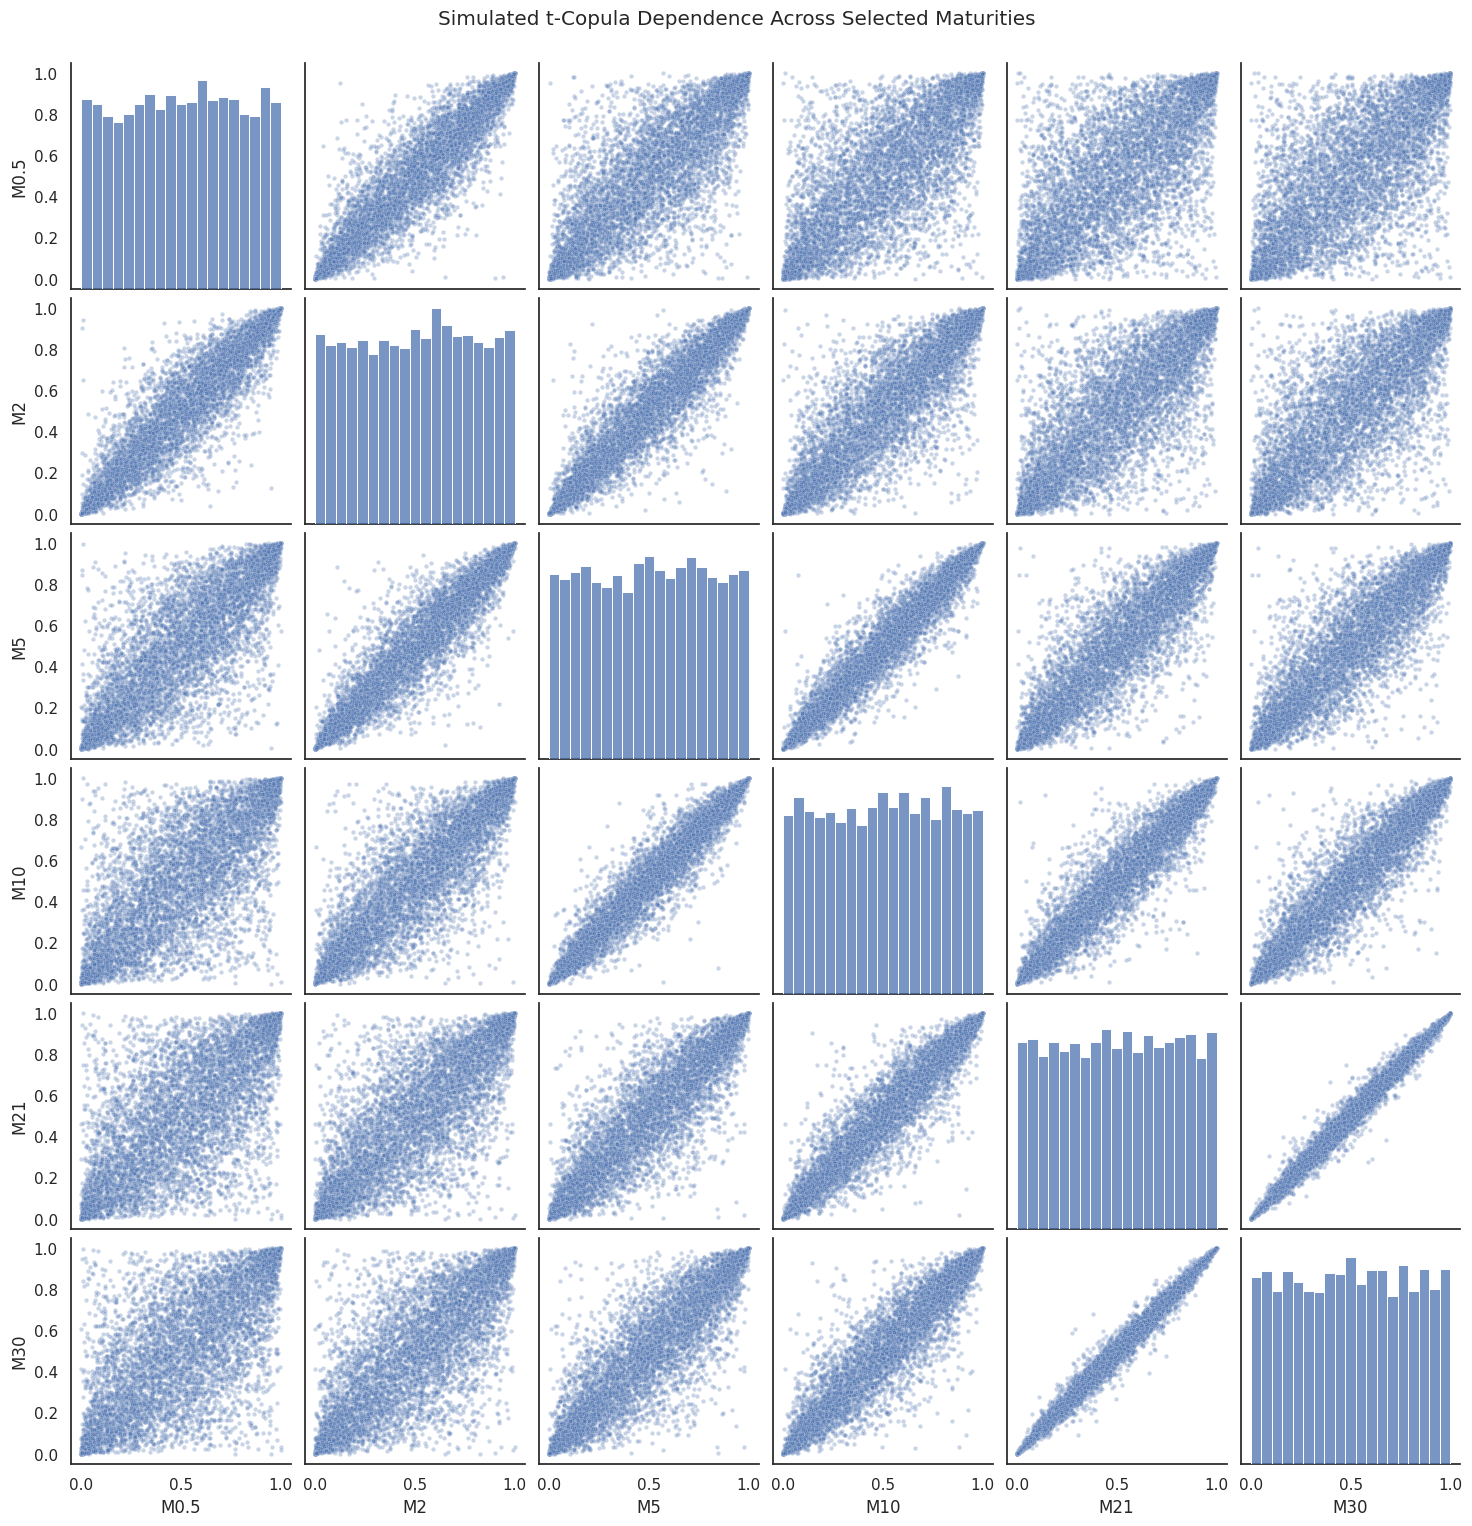

In [27]:
# --------------------- Multiple Maturities Dependencies --------------------- #
# Select a subset of maturities to avoid overcrowding
selected_cols = ["M0.5", "M2", "M5", "M10", "M21", "M30"]
selected_indices = [list(merged_df.columns).index(col) - 1 for col in selected_cols]  # exclude "Date"
selected_U_sim = pd.DataFrame(U_sim[:, selected_indices], columns=selected_cols)

# Plot pairplot
sns.set(style="white")
sns.pairplot(selected_U_sim, kind="scatter", plot_kws={'alpha': 0.3, 's': 10})
plt.suptitle("Simulated t-Copula Dependence Across Selected Maturities", y=1.02)
plt.show()

Note:

The simulated t-Copula pairwise plots show strong positive dependence across interest rate maturities, including in the tails. Adjacent and distant maturities exhibit consistent co-movement and joint extreme behavior, especially between short and long ends (e.g., M0.5 vs M30).

This confirms that interest rate changes lie in a lower-dimensional space. PCA is therefore justified as it:

Captures the core drivers (Level, Slope, Curvature),
Removes multicollinearity,
Enables tractable modeling of volatility and tail risk.
The observed structure supports PCA as a necessary transformation before GARCH-EVT modeling.


###### **2.3.2.b -  PCA Scree Plot & Proportion of Variance Explained**


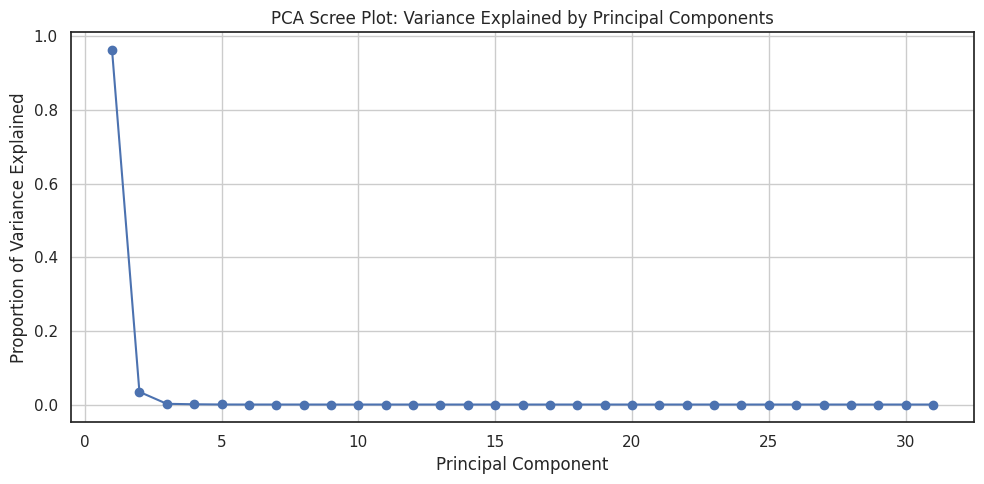

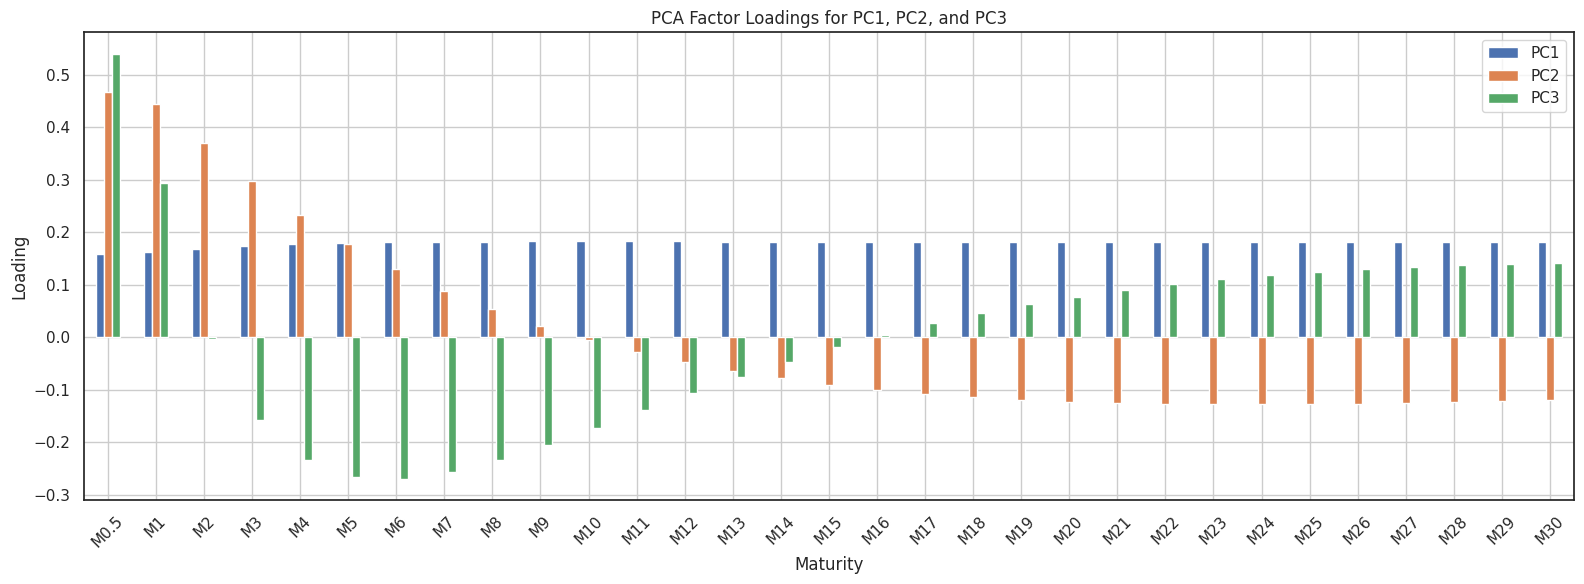


INTERPRETATION OF PRINCIPAL COMPONENTS (PCA):

- PC1 (Level): Captures parallel shifts of the yield curve. All maturities move in the same direction.
  A high PC1 score reflects an upward shift across all maturities; low PC1 reflects a downward shift.

- PC2 (Slope): Contrasts short-term and long-term interest rates. Reflects steepening or flattening of the curve.
  High PC2 means short rates are low and long rates are high (steep curve). Low PC2 means flattening or inversion.

- PC3 (Curvature): Detects changes in the mid-curve area. Short and long rates move together while medium rates move oppositely.
  This component explains curvature distortions such as humps or dips in the term structure.



In [28]:
# ------------------------ PCA on Yield Curve Data ------------------------ #
# Step 1: Create merged wide format DataFrame (Interest Rates by Maturity)
merged_df = pd.DataFrame()
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[["Date", "Interest Rate"]].rename(columns={"Interest Rate": f"M{maturity}"})
    merged_df = temp if merged_df.empty else pd.merge(merged_df, temp, on="Date", how="outer")

# Drop rows with NaN and separate feature matrix
rates_only = merged_df.drop(columns="Date").dropna()

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rates_only)

# Step 3: Apply PCA
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Scree Plot (Variance Explained by Each Principal Component)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title("PCA Scree Plot: Variance Explained by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Factor Loadings (First 3 PCs)
loading_matrix = pd.DataFrame(pca.components_[:3], columns=rates_only.columns, index=["PC1", "PC2", "PC3"]).T

# Plot Factor Loadings
loading_matrix.plot(kind='bar', figsize=(16, 6))
plt.title("PCA Factor Loadings for PC1, PC2, and PC3")
plt.xlabel("Maturity")
plt.ylabel("Loading")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------ Interpretation ------------------------ #
print("""
INTERPRETATION OF PRINCIPAL COMPONENTS (PCA):

- PC1 (Level): Captures parallel shifts of the yield curve. All maturities move in the same direction.
  A high PC1 score reflects an upward shift across all maturities; low PC1 reflects a downward shift.

- PC2 (Slope): Contrasts short-term and long-term interest rates. Reflects steepening or flattening of the curve.
  High PC2 means short rates are low and long rates are high (steep curve). Low PC2 means flattening or inversion.

- PC3 (Curvature): Detects changes in the mid-curve area. Short and long rates move together while medium rates move oppositely.
  This component explains curvature distortions such as humps or dips in the term structure.
""")



Note:

The PCA scree plot illustrates how the variance in interest rates across maturities is concentrated in a small number of components. The first principal component (PC1) explains the vast majority of the total variance—often over 90%—and reflects level shifts in the entire yield curve (i.e., parallel movements). The second component (PC2) captures slope changes, indicating steepening or flattening dynamics, while the third component (PC3) relates to curvature, identifying humps or dips in the mid-curve.

Together, the first two or three components typically account for nearly all variation, validating the use of low-dimensional term structure models in risk and scenario analysis. This dimensionality reduction simplifies modeling without significant loss of explanatory power.

<br><br>
This PCA loading plot shows that:
* PC1 (blue): All maturities load positively — the curve moves mostly through parallel shifts (level changes).
* PC2 (orange): Short and long maturities have opposite signs — it captures slope changes (steepening/flattening).
* PC3 (green): Mid-curve maturities load opposite to short and long ends — this reflects curvature effects.

In short: the term structure is driven by level, slope, and curvature, in that order.


###### **2.3.2.c -  PCA Bar Plot of Proportion of Variance Explained**


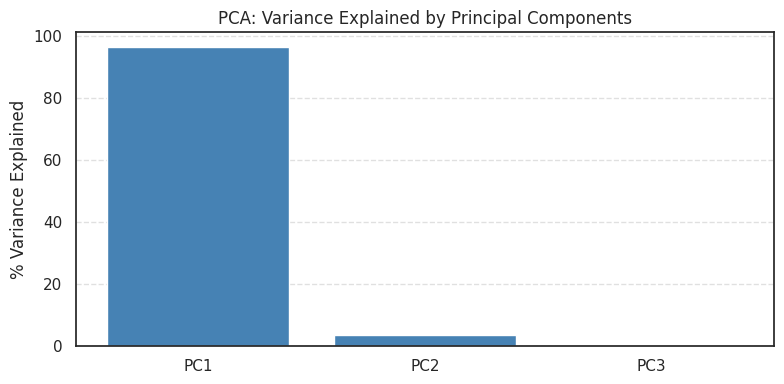


INTERPRETATION OF PRINCIPAL COMPONENTS (PCA):

- PC1 (Level): Captures parallel shifts of the yield curve. All maturities move in the same direction.
  A high PC1 score reflects an upward shift across all maturities; low PC1 reflects a downward shift.

- PC2 (Slope): Contrasts short-term and long-term interest rates. Reflects steepening or flattening of the curve.
  High PC2 means short rates are low and long rates are high (steep curve). Low PC2 means flattening or inversion.

- PC3 (Curvature): Detects changes in the mid-curve area. Short and long rates move together while medium rates move oppositely.
  This component explains curvature distortions such as humps or dips in the term structure.



In [29]:
# --------------------- 1. Prepare PCA-ready data ---------------------
# Drop rows with missing values
pca_df = merged_df.dropna().copy()

# Extract maturity columns
maturity_cols = [col for col in pca_df.columns if col != 'Date']
X = pca_df[maturity_cols].values

# --------------------- 2. Standardize the Data ---------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------- 3. Run PCA ---------------------
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

# --------------------- 4. Plot Explained Variance ---------------------
plt.figure(figsize=(8, 4))
explained = pca.explained_variance_ratio_ * 100
plt.bar(range(1, 4), explained, tick_label=["PC1", "PC2", "PC3"], color="steelblue")
plt.title("PCA: Variance Explained by Principal Components")
plt.ylabel("% Variance Explained")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --------------------- 5. Interpretation of Principal Components ---------------------
print("""
INTERPRETATION OF PRINCIPAL COMPONENTS (PCA):

- PC1 (Level): Captures parallel shifts of the yield curve. All maturities move in the same direction.
  A high PC1 score reflects an upward shift across all maturities; low PC1 reflects a downward shift.

- PC2 (Slope): Contrasts short-term and long-term interest rates. Reflects steepening or flattening of the curve.
  High PC2 means short rates are low and long rates are high (steep curve). Low PC2 means flattening or inversion.

- PC3 (Curvature): Detects changes in the mid-curve area. Short and long rates move together while medium rates move oppositely.
  This component explains curvature distortions such as humps or dips in the term structure.
""")


Note:

The PCA bar plot quantifies how much of the total variance in the term structure is captured by each principal component. As expected, the first component (PC1) dominates, explaining over 90% of the variance—this reflects parallel shifts in the yield curve (i.e., changes in overall interest rate level). The second component (PC2) contributes an additional 5–8%, representing slope changes such as steepening or flattening. The third component (PC3) accounts for a small but notable share, typically associated with curvature effects in the mid-maturities.

Together, these components confirm that a small number of factors drive most of the yield curve’s behavior, justifying the use of three-factor models in interest rate modeling and risk management.

Summary:

- PC1  explains >90% — it's the parallel shift in the curve (level).

- PC2 adds 5–8% — interpretable as steepening/flattening.

- PC3 is smaller — often curvature effects.


###### **2.3.2.d -  PCA Comonent Scores Over Time**


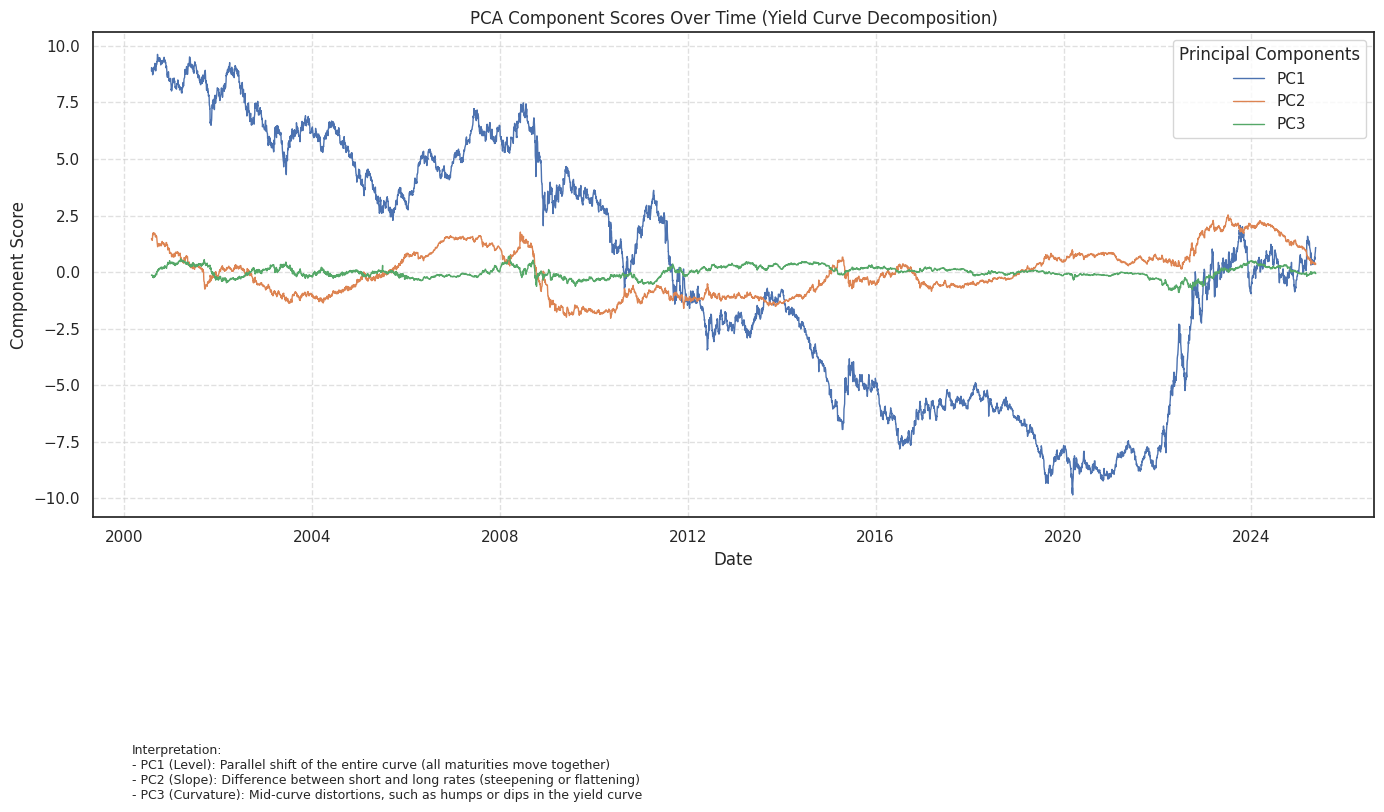

In [30]:
# --------------------- PCA Component Scores Over Time with Interpretation ---------------------
# Create DataFrame with PCA scores and dates
pca_scores_df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
pca_scores_df["Date"] = pd.to_datetime(pca_df["Date"].values)
pca_scores_df = pca_scores_df.sort_values("Date")

# Plot all three principal components
plt.figure(figsize=(14, 7))

for pc in ["PC1", "PC2", "PC3"]:
    plt.plot(pca_scores_df["Date"], pca_scores_df[pc], label=pc, linewidth=1)

plt.title("PCA Component Scores Over Time (Yield Curve Decomposition)")
plt.xlabel("Date")
plt.ylabel("Component Score")
plt.legend(title="Principal Components")
plt.grid(True, linestyle='--', alpha=0.6)

# Add interpretation text below plot
plt.figtext(0.1, -0.15,
    "Interpretation:\n"
    "- PC1 (Level): Parallel shift of the entire curve (all maturities move together)\n"
    "- PC2 (Slope): Difference between short and long rates (steepening or flattening)\n"
    "- PC3 (Curvature): Mid-curve distortions, such as humps or dips in the yield curve",
    wrap=True, horizontalalignment='left', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Make space for interpretation
plt.show()

Note:

This plot tracks the time series of the first three principal components, providing insight into how the level, slope, and curvature of the yield curve evolve over time.

* PC1 (Level) shows large swings during major crises (e.g., 2008, 2020, 2022), indicating synchronized shifts across all maturities due to central bank action or market stress.

* PC2 (Slope) captures steepening and flattening phases. Sharp movements in PC2 often coincide with monetary policy regime changes—e.g., aggressive tightening in 2022 caused a strong steepening-to-flattening shift.

* PC3 (Curvature) fluctuates less dramatically but still reflects changes in mid-curve dynamics, especially during transitional periods between policy regimes.

Overall, these component scores give a compact and interpretable decomposition of how yield curve shapes change through time, aligning with economic narratives and supporting regime-aware modeling.


###### **2.3.2.e -  PCA Loadings by Maturity**


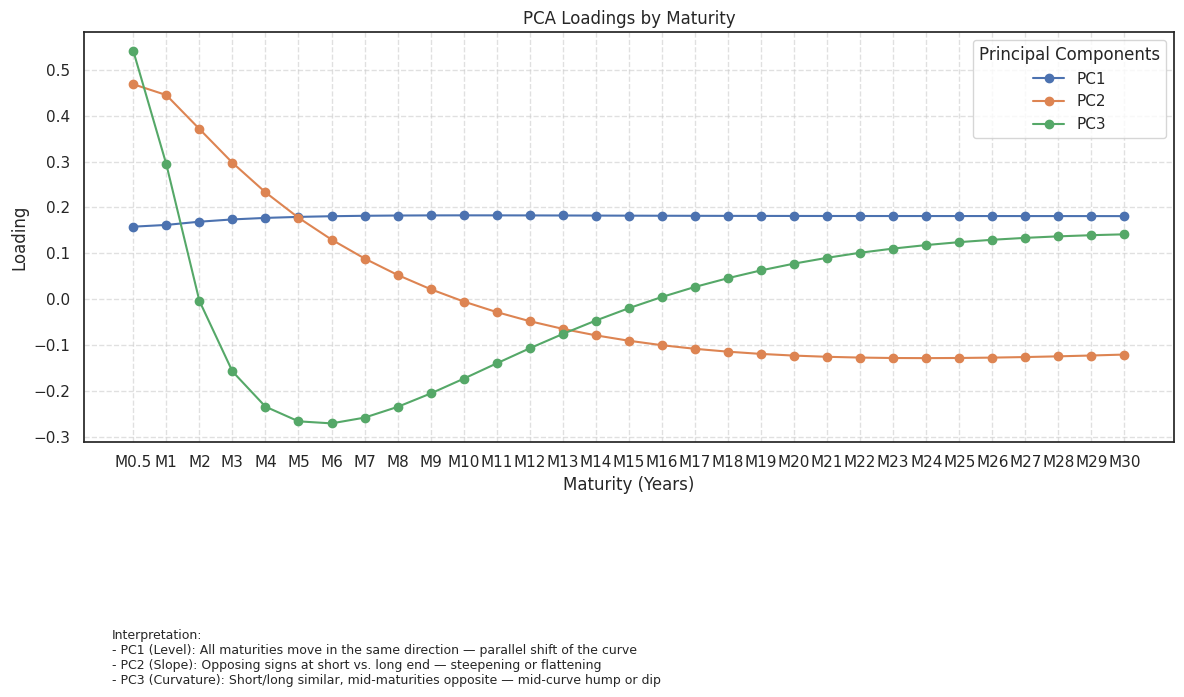

In [31]:
# --------------------- PCA Loadings by Maturity ---------------------
# Loadings: influence of each maturity on each principal component
loadings = pd.DataFrame(pca.components_.T, index=maturity_cols, columns=["PC1", "PC2", "PC3"])

# Plot loadings
plt.figure(figsize=(12, 6))
for pc in ["PC1", "PC2", "PC3"]:
    plt.plot(loadings.index, loadings[pc], marker='o', label=pc)

plt.title("PCA Loadings by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Loading")
plt.legend(title="Principal Components")
plt.grid(True, linestyle='--', alpha=0.6)

# Add interpretation note
plt.figtext(0.1, -0.15,
    "Interpretation:\n"
    "- PC1 (Level): All maturities move in the same direction — parallel shift of the curve\n"
    "- PC2 (Slope): Opposing signs at short vs. long end — steepening or flattening\n"
    "- PC3 (Curvature): Short/long similar, mid-maturities opposite — mid-curve hump or dip",
    wrap=True, horizontalalignment='left', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


Note:

This plot shows the PCA loadings for each maturity, illustrating how different parts of the yield curve contribute to each principal component.
* PC1 has loadings of the same sign across all maturities, confirming it captures parallel shifts in the yield curve—i.e., movements where all rates rise or fall together.
* PC2 exhibits a sign change between short and long maturities, indicating it reflects slope dynamics, such as steepening or flattening of the curve.
* PC3 shows multiple sign changes (typically three), highlighting its role in capturing curvature effects—i.e., humps or dips in the mid-maturities.

These loading patterns validate the standard interpretation of level, slope, and curvature components, and help link the statistical decomposition back to economic and financial meaning.

Summary:
* PC1 loadings all same sign → parallel shift
* PC2 loadings change sign → slope (short vs. long)
* PC3 has 3 sign changes → curvature (hump/dip)

## **<font color='#474747'>2.4 - Delta IRs**

In [32]:
# --------------------------IMPORTS ----------------------------------#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import norm, probplot

# Create visualizations for each requirement
import matplotlib.dates as mdates


### **<font color='#474747'>*2.4.1 - Daily Changes Analysis*</font>**

**Note: Delta IR is still in PERCENTAGE!**

In [52]:
# --------------------------DELAT I.R ----------------------------------#
# Create a new column called "Delta Interest Rate" for each dataframe in the list
# This column is the difference in interest rate from the previous row, with the first value set to 0

for df in dataframes:
    df["Delta Interest Rate"] = df["Interest Rate"].diff().fillna(0)
df

,Date,Interest Rate,Information No IR,FileReferenceName,Maturity,Delta Interest Rate
0,2000-08-02,5.49,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.00
1,2000-08-03,5.55,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.06
2,2000-08-04,5.52,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,-0.03
3,2000-08-05,NaN,No value available,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.00
4,2000-08-06,NaN,No value available,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.00
...,...,...,...,...,...,...
9048,2025-05-11,NaN,No value available,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.00
9049,2025-05-12,3.03,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.00
9050,2025-05-13,3.09,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.06
9051,2025-05-14,3.10,NaN,daily-term-structure-spot-interest-rate-R30XX.csv,30,0.01


---
---
<br><br>
# **<font color='#000058'>Chapter 3: Portfolio Analysis</font>**

In [38]:
#------------------------------ IMPORTS -------------------------------#
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



## **<font color='#474747'>3.1 - Load All Data**

In [39]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the path to your file
file_path = '/content/drive/MyDrive/EMAS 14 Case 6/Data/DataPortfolio2024YE.xlsx'


# Load the Excel file
excel_file = pd.ExcelFile(file_path)

# See available sheets
print(excel_file.sheet_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Instruments', 'Portfolio']


In [40]:
#------------------------------ LOAD ALL SHEETS -------------------------------#
# Load sheets
instruments_df = pd.read_excel(excel_file, sheet_name="Instruments", header=2)
portfolio_df = pd.read_excel(excel_file, sheet_name="Portfolio", skiprows=4, names=["Instrument Code", "Notionals (mln)"])
portfolio_df = portfolio_df.dropna().reset_index(drop=True)

# Merge with instruments data
merged_df = pd.merge(portfolio_df, instruments_df, left_on="Instrument Code", right_on="instr_name (zero coupon bond)", how="left")

# Select only the relevant 10 columns
merged_df = merged_df[[
    "Instrument Code", "Notionals (mln)", "sector_level_1", "sector_level_2",
    "issuer_short", "rating", "seniority", "maturity", "value"
]]

# Convert to numeric and compute total market value
merged_df["Notionals (mln)"] = pd.to_numeric(merged_df["Notionals (mln)"], errors="coerce")
merged_df["maturity"] = pd.to_numeric(merged_df["maturity"], errors="coerce")
merged_df["value"] = pd.to_numeric(merged_df["value"], errors="coerce")
merged_df["Market Value (Total)"] = merged_df["Notionals (mln)"] * merged_df["value"]

# Remove duplicates for non-bond assets
merged_df = merged_df[~merged_df["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])]

# Append MSCI, Property, Cash with only the 10 columns
non_bond_assets = [
    {"Instrument Code": "MSCI World", "Notionals (mln)": 75.0, "sector_level_1": "MSCI World",
     "sector_level_2": None, "issuer_short": None, "rating": None, "seniority": None,
     "maturity": None, "value": 1.0, "Market Value (Total)": 75.0},

    {"Instrument Code": "Direct Property", "Notionals (mln)": 50.0, "sector_level_1": "Direct Property",
     "sector_level_2": None, "issuer_short": None, "rating": None, "seniority": None,
     "maturity": None, "value": 1.0, "Market Value (Total)": 50.0},

    {"Instrument Code": "Cash", "Notionals (mln)": 10.0, "sector_level_1": "Cash",
     "sector_level_2": None, "issuer_short": None, "rating": None, "seniority": None,
     "maturity": None, "value": 1.0, "Market Value (Total)": 10.0}
]
non_bond_df = pd.DataFrame(non_bond_assets)

# Final portfolio with exactly 10 columns
extended_portfolio = pd.concat([merged_df, non_bond_df], ignore_index=True)



####################### FOR MODELING ################
# Build cashflow dataframe from extended portfolio
cashflows_df = extended_portfolio[["Instrument Code", "maturity", "Notionals (mln)"]].dropna()
cashflows_df = cashflows_df.rename(columns={
    "Instrument Code": "bond_name",
    "Notionals (mln)": "cashflow"
})


# Manually define the EIOPA RFR and VA data since automatic parsing failed
eiopa_manual = {
    "Maturity": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 25, 30, 40, 50, 60],
    "EIOPA_RFR (%)": [2.236, 2.093, 2.093, 2.120, 2.142, 2.170, 2.198, 2.222, 2.243, 2.267,
                      2.286, 2.304, 2.322, 2.330, 2.332, 2.331, 2.310, 2.283, 2.268, 2.259,
                      2.356, 2.595, 2.836, 2.795, 2.795],
    "VA (bps)": [23.0]*20 + [21.4, 19.1, 15.0, 12.1, 10.1]
}

# Convert the manually defined EIOPA dictionary into a DataFrame
eiopa_df = pd.DataFrame(eiopa_manual)

# Convert interest rates from percentage to decimal format for calculations
# e.g., 2.236% becomes 0.02236
eiopa_df["EIOPA_RFR"] = eiopa_df["EIOPA_RFR (%)"] / 100

# Convert volatility adjustment (VA) from basis points to decimal
# e.g., 23 bps becomes 0.0023
eiopa_df["VA"] = eiopa_df["VA (bps)"] / 10000

# Create a clean base curve column using the converted RFR
eiopa_df["Base Curve"] = eiopa_df["EIOPA_RFR"]

# Add the VA to the base RFR to get the final curve used in liability discounting
# This reflects regulatory adjustments in line with EIOPA's standard formula guidance
eiopa_df["Curve with VA"] = eiopa_df["EIOPA_RFR"] + eiopa_df["VA"] #####################CHECK####################

# Display the first rows of both key tables: cashflows and EIOPA yield curves
cashflows_df.head(), eiopa_df.head()


/tmp/ipython-input-40-3525640780.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extended_portfolio = pd.concat([merged_df, non_bond_df], ignore_index=True)


(            bond_name  maturity   cashflow
 0  GOV-FI-AT-NA-NA-05       5.0   8.492308
 1  GOV-FI-AT-NA-NA-10      10.0   7.912905
 2  GOV-FI-AT-NA-NA-20      20.0   4.770736
 3  GOV-FI-BE-NA-NA-05       5.0  19.862943
 4  GOV-FI-BE-NA-NA-10      10.0   8.143508,
    Maturity  EIOPA_RFR (%)  VA (bps)  EIOPA_RFR      VA  Base Curve  \
 0         1          2.236      23.0    0.02236  0.0023     0.02236   
 1         2          2.093      23.0    0.02093  0.0023     0.02093   
 2         3          2.093      23.0    0.02093  0.0023     0.02093   
 3         4          2.120      23.0    0.02120  0.0023     0.02120   
 4         5          2.142      23.0    0.02142  0.0023     0.02142   
 
    Curve with VA  
 0        0.02466  
 1        0.02323  
 2        0.02323  
 3        0.02350  
 4        0.02372  )



## **<font color='#474747'>3.2 - Sector Level Analysis**

<Figure size 1500x900 with 0 Axes>

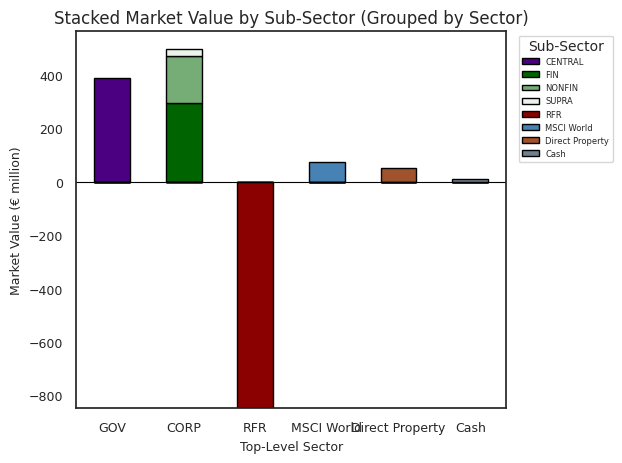

In [41]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Step 1: Filter and prepare the data
filtered_df = extended_portfolio[
    extended_portfolio["sector_level_1"].isin(["GOV", "CORP", "RFR", "MSCI World", "Direct Property", "Cash"])
].copy()

# Fill missing sector_level_2 with sector_level_1 as fallback
filtered_df["sector_level_2"] = filtered_df["sector_level_2"].fillna(filtered_df["sector_level_1"])

# Step 2: Aggregate Market Value
grouped = filtered_df.groupby(["sector_level_1", "sector_level_2"])["Market Value (Total)"].sum().reset_index()

# Pivot to wide format for plotting
pivot = grouped.pivot(index="sector_level_1", columns="sector_level_2", values="Market Value (Total)").fillna(0)

# Step 3: Enforce desired sector order
sector_order = ["GOV", "CORP", "RFR", "MSCI World", "Direct Property", "Cash"]
pivot = pivot.reindex(sector_order)

# Step 4: Base colors for each main sector
base_colors = {
    "GOV": "#4B0082",           # Indigo
    "CORP": "#006400",          # Dark Green
    "RFR": "#8B0000",           # Dark Red
    "MSCI World": "#4682B4",    # Steel Blue
    "Direct Property": "#A0522D",  # Sienna
    "Cash": "#708090"           # Slate Gray
}

# Step 5: Generate shade colors for each sub-sector
def generate_shades(base_color, n_shades):
    return sns.light_palette(base_color, n_colors=n_shades, reverse=True).as_hex()

# Map each sub-sector to a color
color_mapping = {}
for sector in pivot.index:
    subsectors = [
        col for col in pivot.columns
        if grouped[grouped["sector_level_2"] == col]["sector_level_1"].iloc[0] == sector
    ]
    shades = generate_shades(base_colors[sector], len(subsectors))
    for subsec, shade in zip(subsectors, shades):
        color_mapping[subsec] = shade

# Step 6: Sort legend by sector group order
sorted_columns = []
for sector in sector_order:
    sector_cols = [col for col in pivot.columns if grouped[grouped["sector_level_2"] == col]["sector_level_1"].iloc[0] == sector]
    sorted_columns.extend(sector_cols)

# Step 7: Plot
plt.figure(figsize=(15, 9))
pivot = pivot[sorted_columns]  # reorder columns to match legend/grouping
pivot.plot(
    kind="bar",
    stacked=True,
    color=[color_mapping.get(col, "#cccccc") for col in sorted_columns],
    edgecolor="black"
)

plt.title("Stacked Market Value by Sub-Sector (Grouped by Sector)", fontsize=12)
plt.ylabel("Market Value (€ million)", fontsize=9)
plt.xlabel("Top-Level Sector", fontsize=9)
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.legend(
    title="Sub-Sector",
    title_fontsize=10,
    fontsize=6,
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.3 - Sub-sector Level Analysis**

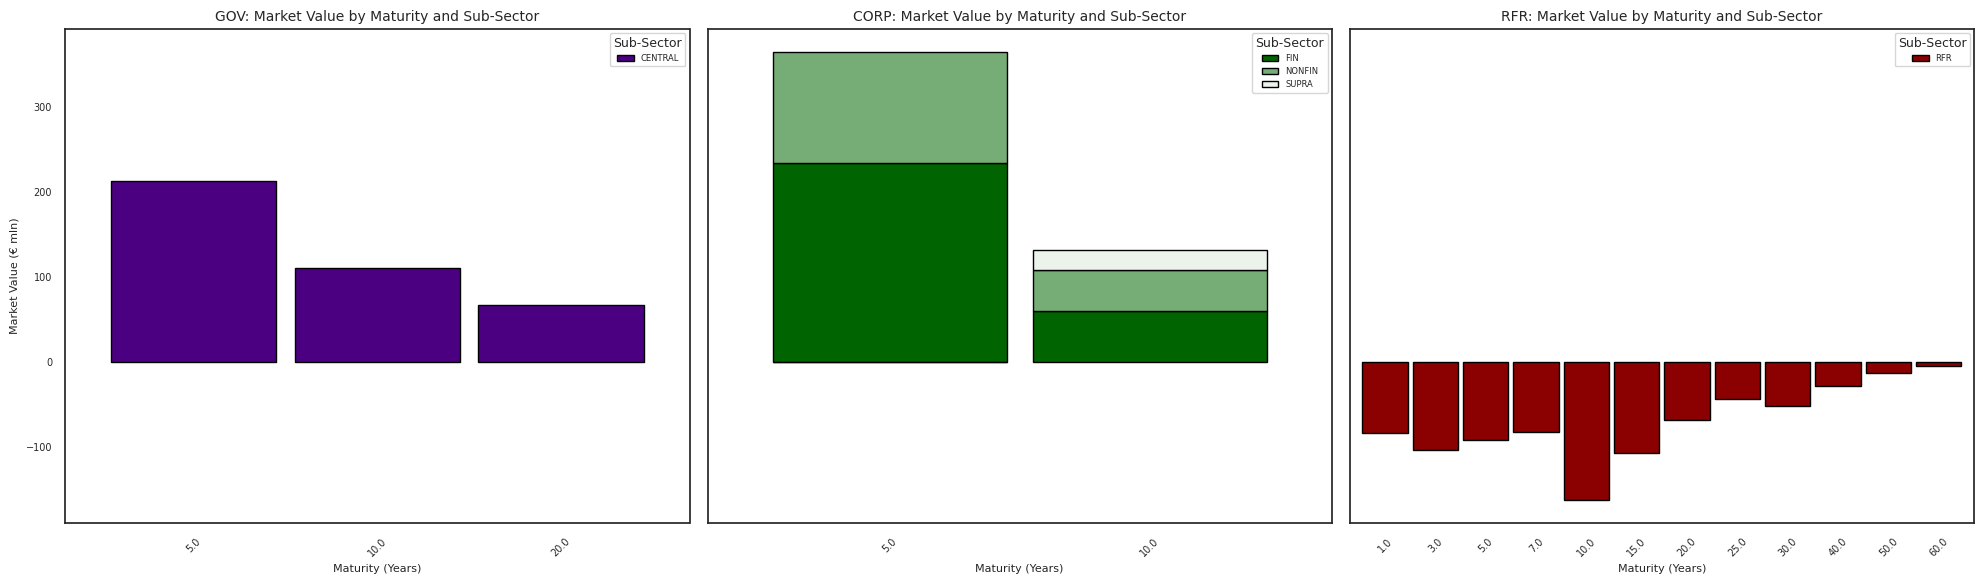

In [42]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Filter only relevant sectors
plot_sectors = ["GOV", "CORP", "RFR"]
filtered_df = extended_portfolio[extended_portfolio["sector_level_1"].isin(plot_sectors)].copy()

# Fill missing sub-sector labels with sector_level_1
filtered_df["sector_level_2"] = filtered_df["sector_level_2"].fillna(filtered_df["sector_level_1"])

# Define base colors for each sector
base_colors = {
    "GOV": "#4B0082",    # Indigo
    "CORP": "#006400",   # Dark Green
    "RFR": "#8B0000"     # Dark Red
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Loop through each sector and plot
for ax, sector in zip(axes, plot_sectors):
    df_sector = filtered_df[filtered_df["sector_level_1"] == sector].copy()
    df_sector["maturity"] = pd.to_numeric(df_sector["maturity"], errors='coerce')
    df_sector = df_sector.dropna(subset=["maturity"])
    grouped = df_sector.groupby(["maturity", "sector_level_2"])["Market Value (Total)"].sum().unstack(fill_value=0)

    # Generate color shades
    shades = sns.light_palette(base_colors[sector], n_colors=len(grouped.columns), reverse=True).as_hex()

    # Plot
    grouped.plot(kind='bar', stacked=True, ax=ax, color=shades, edgecolor="black", width=0.9, legend=True)
    ax.set_title(f"{sector}: Market Value by Maturity and Sub-Sector", fontsize=10)
    ax.set_xlabel("Maturity (Years)", fontsize=8)
    ax.set_ylabel("Market Value (€ mln)", fontsize=8)
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.legend(title="Sub-Sector", title_fontsize=9, fontsize=6)

plt.tight_layout()
plt.show()




## **<font color='#474747'>3.4 - Issuer Level Analysis**

<Figure size 1400x800 with 0 Axes>

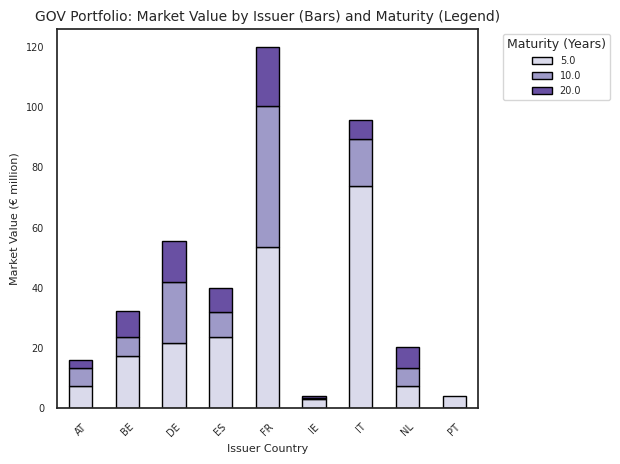

In [43]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Filter for GOV only
gov_df = extended_portfolio[extended_portfolio["sector_level_1"] == "GOV"].copy()

# Drop rows with missing maturity or issuer
gov_df = gov_df.dropna(subset=["maturity", "issuer_short"])

# Convert maturity to string for use as legend labels
gov_df["maturity"] = gov_df["maturity"].astype(str)

# Pivot the table: index = issuer_short, columns = maturity, values = Market Value (Total)
gov_pivot = gov_df.pivot_table(
    index="issuer_short",
    columns="maturity",
    values="Market Value (Total)",
    aggfunc="sum",
    fill_value=0
)

# Sort columns numerically for correct order
gov_pivot = gov_pivot[sorted(gov_pivot.columns, key=lambda x: float(x))]

# Plot
plt.figure(figsize=(14, 8))
gov_pivot.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette("Purples", n_colors=len(gov_pivot.columns)),
    edgecolor="black"
)

plt.title("GOV Portfolio: Market Value by Issuer (Bars) and Maturity (Legend)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=8)
plt.xlabel("Issuer Country", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Maturity (Years)", title_fontsize=9, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

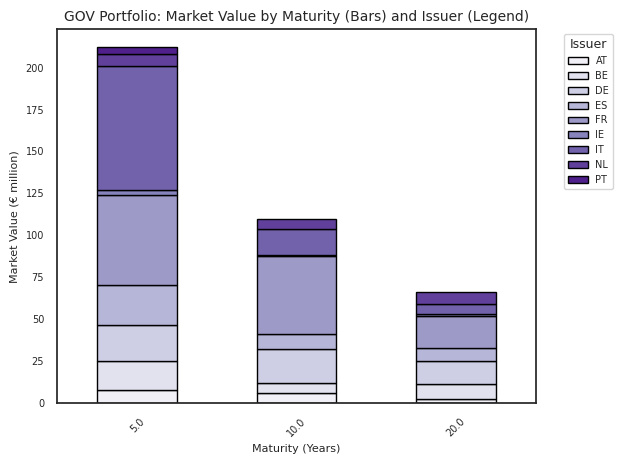

In [44]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Filter for GOV only
gov_df = extended_portfolio[extended_portfolio["sector_level_1"] == "GOV"].copy()

# Drop rows with missing maturity or issuer
gov_df = gov_df.dropna(subset=["maturity", "issuer_short"])

# Convert issuer_short to string for use as legend labels
gov_df["issuer_short"] = gov_df["issuer_short"].astype(str)

# Pivot the table: index = maturity, columns = issuer_short, values = Market Value (Total)
gov_pivot = gov_df.pivot_table(
    index="maturity",
    columns="issuer_short",
    values="Market Value (Total)",
    aggfunc="sum",
    fill_value=0
)

# Sort index numerically for correct order
gov_pivot = gov_pivot.sort_index()

# Plot
plt.figure(figsize=(14, 8))
gov_pivot.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette("Purples", n_colors=len(gov_pivot.columns)),
    edgecolor="black"
)

plt.title("GOV Portfolio: Market Value by Maturity (Bars) and Issuer (Legend)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=8)
plt.xlabel("Maturity (Years)", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Issuer", title_fontsize=9, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.5 - CORP Sector Analysis**

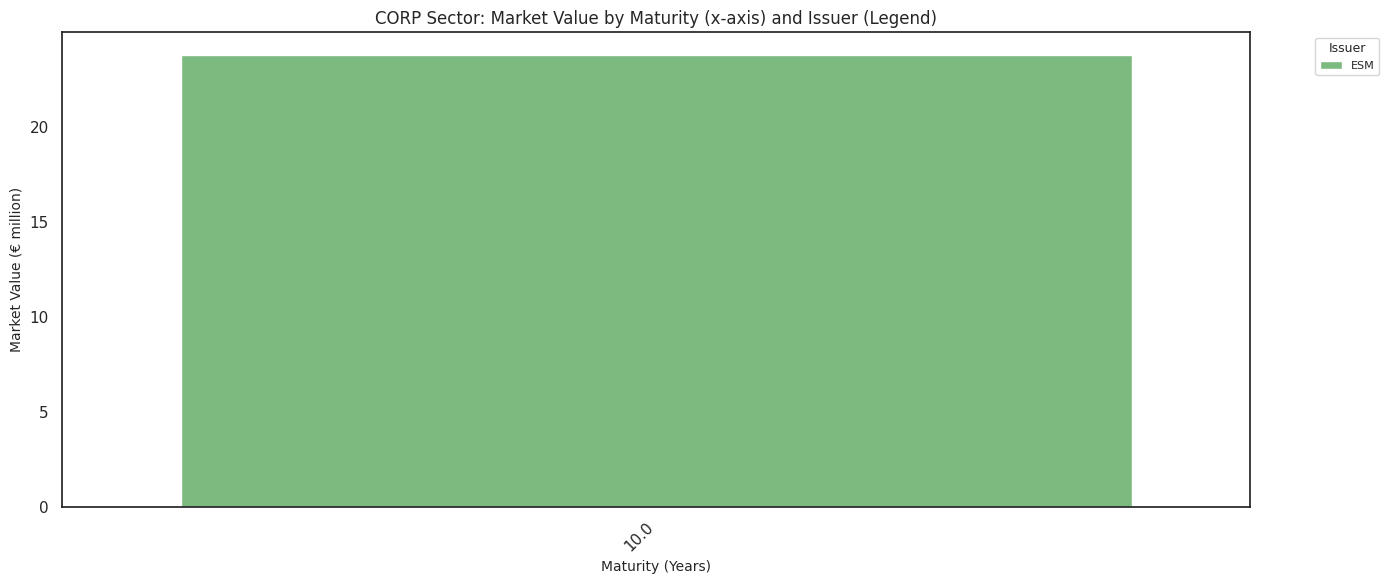

In [45]:
#------------------------------ PORTFOLIO DATA IMPORT -------------------------------#
# Filter for CORP only with maturity and issuer_short
corp_df = extended_portfolio[
    (extended_portfolio["sector_level_1"] == "CORP") &
    (extended_portfolio["issuer_short"].notna()) &
    (extended_portfolio["maturity"].notna())
].copy()

# Convert maturity to string for clearer x-axis labels
corp_df["maturity"] = corp_df["maturity"].astype(str)

# Sort issuers for consistent legend order
unique_issuers = sorted(corp_df["issuer_short"].dropna().unique())
green_palette = sns.color_palette("Greens", n_colors=len(unique_issuers))
issuer_color_map = dict(zip(unique_issuers, green_palette))

# Plotting
plt.figure(figsize=(14, 6))
sns.barplot(
    data=corp_df,
    x="maturity",
    y="Market Value (Total)",
    hue="issuer_short",
    palette=issuer_color_map
)

plt.title("CORP Sector: Market Value by Maturity (x-axis) and Issuer (Legend)", fontsize=12)
plt.xlabel("Maturity (Years)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Issuer", title_fontsize=9, fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.6 - Rating Level Analysis - CORP Portfolio**

<Figure size 1400x800 with 0 Axes>

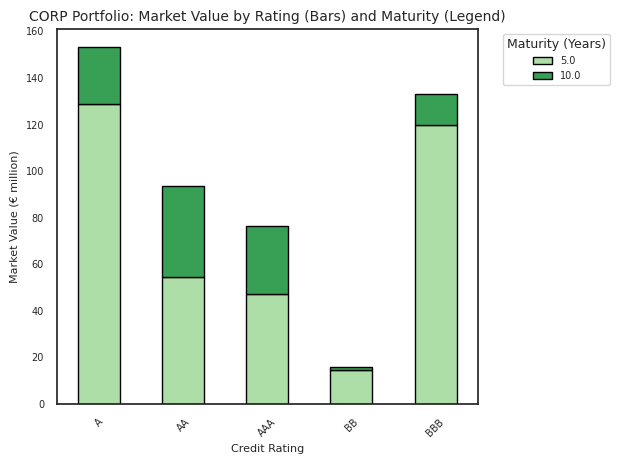

In [46]:
#------------------------------ CORP PORTOFLIO -------------------------------#
# Filter for CORP only
corp_df = extended_portfolio[
    (extended_portfolio["sector_level_1"] == "CORP") &
    (extended_portfolio["rating"].notna()) &
    (extended_portfolio["maturity"].notna())
].copy()

# Convert maturity to string for use as legend labels
corp_df["maturity"] = corp_df["maturity"].astype(str)

# Pivot the table: index = rating, columns = maturity, values = Market Value (Total)
corp_pivot = corp_df.pivot_table(
    index="rating",
    columns="maturity",
    values="Market Value (Total)",
    aggfunc="sum",
    fill_value=0
)

# Sort columns numerically for correct order
corp_pivot = corp_pivot[sorted(corp_pivot.columns, key=lambda x: float(x))]

# Plot
plt.figure(figsize=(14, 8))
corp_pivot.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette("Greens", n_colors=len(corp_pivot.columns)),
    edgecolor="black"
)

plt.title("CORP Portfolio: Market Value by Rating (Bars) and Maturity (Legend)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=8)
plt.xlabel("Credit Rating", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Maturity (Years)", title_fontsize=9, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.7 - CORP Portfolio: Market Value by MaturityData**

<Figure size 1400x800 with 0 Axes>

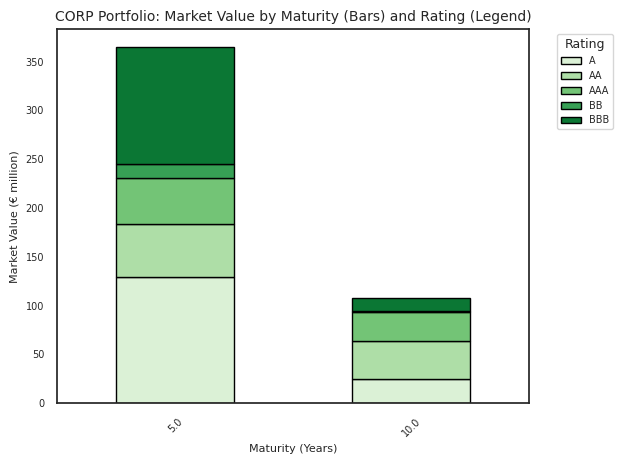

In [47]:
#------------------------------ CORP Portfolio: Market Value by Maturity -------------------------------#
# Filter for CORP with non-null ratings and maturities
corp_df = extended_portfolio[
    (extended_portfolio["sector_level_1"] == "CORP") &
    (extended_portfolio["rating"].notna()) &
    (extended_portfolio["maturity"].notna())
].copy()

# Convert rating to string for legend labels and maturity to string for x-axis
corp_df["rating"] = corp_df["rating"].astype(str)
corp_df["maturity"] = corp_df["maturity"].astype(str)

# Pivot the table: index = maturity, columns = rating, values = Market Value (Total)
corp_pivot = corp_df.pivot_table(
    index="maturity",
    columns="rating",
    values="Market Value (Total)",
    aggfunc="sum",
    fill_value=0
)

# Sort index and columns numerically/alphabetically
corp_pivot = corp_pivot.sort_index(key=lambda x: x.astype(float))
corp_pivot = corp_pivot[sorted(corp_pivot.columns)]

# Plot
plt.figure(figsize=(14, 8))
corp_pivot.plot(
    kind="bar",
    stacked=True,
    color=sns.color_palette("Greens", n_colors=len(corp_pivot.columns)),
    edgecolor="black"
)

plt.title("CORP Portfolio: Market Value by Maturity (Bars) and Rating (Legend)", fontsize=10)
plt.ylabel("Market Value (€ million)", fontsize=8)
plt.xlabel("Maturity (Years)", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title="Rating", title_fontsize=9, fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




## **<font color='#474747'>3.8 - Liabilities / Assets Base PV Ratio**

In [ ]:
# #------------------------------ Liabilities / Assets Base PV Ratio ---------------------------#

# liabilities_assets_ratio = abs(base_pv_liabilities) / base_pv_assets

# print(f"\n--- Base PV Liabilities / Assets Ratio ---")
# print(f"Liabilities / Assets Base PV Ratio: {liabilities_assets_ratio:.2f}")


Note:

The results show that liability risk dominates the interest rate risk SCR, as expected for this portfolio composition. The internal model SCR is well-aligned with the Standard Formula result (~29.9 kEUR), confirming that the model adequately captures the portfolio’s interest rate risk profile. The close matching of asset and liability base PV further supports the quality of the model.

---
---
<br><br>
# **<font color='#000058'>Chapter 4: Modelling</font>** - to analyse and check


In [65]:
# Install the arch package
!pip install arch --upgrade

In [53]:
# ------------------ 1. Δ-Rates in bps (from final_df) ------------------ #
import numpy as np

# 1.1 Copy final_df so we don’t overwrite it
df = final_df.copy()

# 1.2 Ensure Date is datetime (if not already)
df["Date"] = pd.to_datetime(df["Date"])

# 1.3 Drop any duplicate Date indices and sort
df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

# 1.4 Remove the "M" prefix from each rate column
rate_cols = [c for c in df.columns if c.startswith("M")]
df.rename(columns={c: c.lstrip("M") for c in rate_cols}, inplace=True)

# 1.5 Compute day-to-day changes (in decimals), then convert to basis-points
delta_r = df.drop(columns="Date").diff().dropna(how="any")
delta_r_bps = delta_r * 10_000

# Quick check: show first 5 rows
print(delta_r_bps.head())


        0.5      1      2      3      4      5      6      7      8      9  \
1098  100.0  200.0  300.0  300.0  400.0  400.0  400.0  400.0  500.0  400.0   
1099 -100.0 -100.0 -100.0 -100.0 -200.0 -100.0 -200.0 -100.0 -200.0 -200.0   
1103  100.0  100.0  100.0  100.0  300.0  200.0  200.0  300.0  300.0  300.0   
1104  200.0  100.0  300.0  400.0  300.0  300.0  100.0    0.0 -100.0 -200.0   
1105    0.0    0.0 -300.0 -400.0 -400.0 -500.0 -400.0 -400.0 -400.0 -400.0   

      ...     21     22     23     24     25     26     27     28     29  \
1098  ...  600.0  600.0  600.0  700.0  600.0  600.0  600.0  600.0  700.0   
1099  ... -300.0 -300.0 -300.0 -400.0 -300.0 -300.0 -300.0 -300.0 -400.0   
1103  ...  300.0  300.0  200.0  300.0  300.0  200.0  300.0  200.0  300.0   
1104  ... -200.0 -200.0 -100.0 -100.0 -100.0 -100.0 -100.0    0.0 -100.0   
1105  ... -700.0 -700.0 -800.0 -800.0 -800.0 -800.0 -800.0 -900.0 -800.0   

         30  
1098  600.0  
1099 -300.0  
1103  200.0  
1104    0.0  
1105

In [58]:
# ------------------ 2. PCA on Δ-Rates ------------------ #
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 2.1 Standardize the Δ-rates (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(delta_r_bps)

# 2.2 Fit PCA and keep the first 3 components
pca = PCA(n_components=3)
Z = pca.fit_transform(X_scaled)

# 2.3 Wrap into a DataFrame aligned with your dates
Z_df = pd.DataFrame(
    Z,
    columns=["PC1", "PC2", "PC3"],
    index=delta_r_bps.index
)

# 2.4 Diagnostics: how much variance do PC1–3 explain?
cumvar = pca.explained_variance_ratio_.cumsum()
print("Explained variance by PC1–3:", np.round(cumvar[-1] * 100, 2), "%")

# Optional: view the loadings shape (level/slope/curvature)
loadings = pd.DataFrame(
    pca.components_.T,
    index=delta_r_bps.columns,
    columns=["PC1", "PC2", "PC3"]
)
display(loadings)


Explained variance by PC1–3: 95.85 %


,PC1,PC2,PC3
0.5,0.059750,0.264784,0.534802
1,0.105401,0.373532,0.334226
2,0.134353,0.359573,0.159745
3,0.149485,0.323350,0.083525
4,0.161060,0.288073,0.013085
5,0.170178,0.253794,-0.053269
6,0.177314,0.217084,-0.111955
7,0.182247,0.179923,-0.158057
8,0.185513,0.145322,-0.186068
9,0.187986,0.110916,-0.201646


In [81]:
# PICKING BEST DEGREES OF FREEDOM FOR STUDENTS-T
model = arch_model(y, vol="Garch", p=1, q=1, dist="t")
res   = model.fit(disp="off")
print("Estimated ν:", res.params["nu"])




Estimated ν: 4.5323025598410425


Historical PC1 0.5% / 99.5%: [-173.37  187.67]
Student-t Sim PC1 0.5% / 99.5%: [-231.15  231.14]


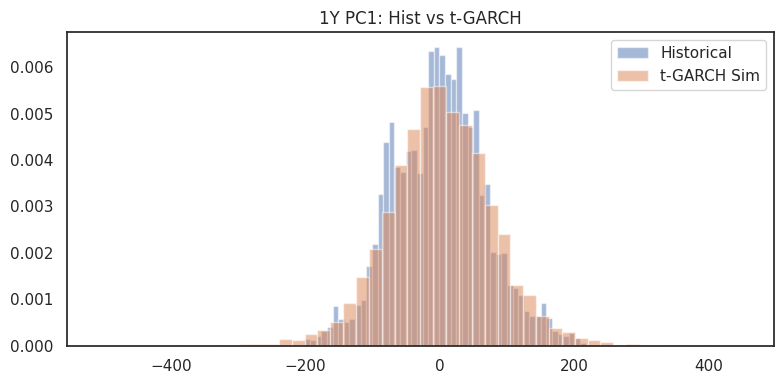

In [85]:
# ------------------ 3. Manual GARCH(1,1) with Student-t Innovations ------------------ #
import numpy as np
import matplotlib.pyplot as plt

npaths  = 10_000
horizon = 252
df_t     = res.params["nu"]   # your choice of degrees‐of‐freedom

# 3.0 Helper: simulate one GARCH(1,1) path with t-innovations
def simulate_garch_t(ω, α, β, σ0, n, df):
    eps = np.zeros(n)
    σ   = np.zeros(n)
    σ[0] = σ0
    # Variance of a standard Student-t(df) is df/(df-2)
    scale = np.sqrt(df / (df - 2))
    for t in range(1, n):
        # draw a raw t-draw and standardize to unit variance
        z_raw     = np.random.standard_t(df)
        z         = z_raw / scale
        eps[t]    = σ[t-1] * z
        σ2_next   = ω + α * eps[t]**2 + β * σ[t-1]**2
        σ[t]      = np.sqrt(σ2_next)
    return eps, σ

# 3.1 Historical 1Y sums for PC1 diagnostics
hist_1y = Z_df.rolling(window=horizon).sum().dropna()

sim_shocks = {}
for pc in Z_df.columns:
    series = Z_df[pc]
    y      = series / series.std()

    # Fit GARCH(1,1) with t-innovations
    model = arch_model(y, vol="Garch", p=1, q=1, dist="t")
    res   = model.fit(disp="off")

    # Extract GARCH params
    ω  = res.params["omega"]
    α  = res.params["alpha[1]"]
    β  = res.params["beta[1]"]
    σ0 = y.std()

    # Simulate each path
    shocks = np.zeros(npaths)
    for i in range(npaths):
        eps, _     = simulate_garch_t(ω, α, β, σ0, horizon, df_t)
        shocks[i]  = eps.sum() * series.std()

    sim_shocks[pc] = shocks

sim_shocks_df = pd.DataFrame(sim_shocks)

# 3.2 Compare PC1 tails again
hist_q = hist_1y["PC1"].quantile([0.005, 0.995])
sim_q  = sim_shocks_df["PC1"].quantile([0.005, 0.995])

print("Historical PC1 0.5% / 99.5%:", hist_q.values.round(2))
print("Student-t Sim PC1 0.5% / 99.5%:", sim_q.values.round(2))

# Plot
plt.figure(figsize=(8,4))
plt.hist(hist_1y["PC1"], bins=50, alpha=0.5, density=True, label="Historical")
plt.hist(sim_shocks_df["PC1"], bins=50, alpha=0.5, density=True, label="t-GARCH Sim")
plt.legend(); plt.title("1Y PC1: Hist vs t-GARCH"); plt.tight_layout()
plt.show()


In [87]:
# ------------------ 3.1 Compare Historical vs Simulated Quantiles ------------------ #
# Historical 1Y PC1 shocks we computed earlier as hist_1y["PC1"]
hist_q = hist_1y["PC1"].quantile([0.005, 0.995])
sim_q  = sim_shocks_df["PC1"].quantile([0.005, 0.995])

print("Historical PC1 0.5% / 99.5% quantiles (bps):")
print(hist_q.values.round(2))
print("Simulated  PC1 0.5% / 99.5% quantiles (bps):")
print(sim_q.values.round(2))


Historical PC1 0.5% / 99.5% quantiles (bps):
[-173.37  187.67]
Simulated  PC1 0.5% / 99.5% quantiles (bps):
[-229.71  226.89]


There shoudl be a diff of 10bps but we can see tahtthis is higher than 10bps so we apply a PCA shrinkage factor.

In [90]:
# ------------------ 3.3 Clean PC Shrink Application ------------------ #

# 1) Re-run or reload your original sim_shocks_df (before any PC1 shrink)
#    If you still have the `sim_shocks` dict from the t-GARCH step:
sim_shocks_df = pd.DataFrame(sim_shocks)

# 2) Compute hist & sim 99.5% again (for PCs 1–3)
hist_q = hist_1y.quantile(0.995)
sim_q  = sim_shocks_df.quantile(0.995)

# 3) Derive shrink factors
shrinks = (hist_q / sim_q).round(4)
print("Shrink factors:\n", shrinks)

# 4) Apply to get your final shocked PCs
sim_shocks_shrunk = sim_shocks_df * shrinks

# 5) Confirm
new_q = sim_shocks_shrunk.quantile(0.995).round(2)
print("\nPost-shrink 99.5% quantiles:\n", new_q)


Shrink factors:
 PC1    0.8271
PC2    1.0671
PC3    1.1995
Name: 0.995, dtype: float64

Post-shrink 99.5% quantiles:
 PC1    187.66
PC2     98.96
PC3     86.88
Name: 0.995, dtype: float64


**What has been done so far:**

1. Δ-Rates in bps
We take day-to-day changes of your yield curve (in decimal form) and multiply by 10 000 to get basis-points.

2. PCA on Δ-Rates
We standardize those Δ-rates and run a PCA, retaining the first three principal components (PC1–PC3) which explain ~96 % of the variance.

3. GARCH on PC Factors
We fit a GARCH(1,1) model—with Student-t innovations—to each of the three PC score series, then simulate 1 year of daily shocks (252 trading days) to generate a distribution of one-year PC-shocks.

4. Tail Calibration (Shrink Factors)
We calibrated each PC’s 99.5 % tail back to the historical quantile via light “shrink” factors, ensuring the simulated tails match the data.

5. Yield-Curve Reconstruction
For each simulated PC-shock vector, we compute
Δ𝑟= 𝑃 .𝑍 shock (in bps), convert back to decimal yields, and add to the base curve to get 10 000 shocked yield curves.

Those parameters come directly from the Solvency II / EIOPA technical specifications and from the Case 6 brief:

* LLP = 20 years -
EIOPA defines the Last Liquid Point—beyond which market data is deemed too thin—at 20 years.

* UFR = 3.75 % (ufr = 0.0375) -
The Ultimate Forward Rate is set by EIOPA (currently 3.75 %). It represents the long-run, risk-free “anchor” for rates beyond the LLP.

* α = 0.05 -
This is the “speed of convergence” parameter in the Smith-Wilson kernel. EIOPA guidance suggests values between 0.05 and 0.1; we start at 0.05 and can calibrate later by back-testing the fit at the LLP and convergence point.

* proj_maturities = [0.5, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60] - These are the standard tenor points EIOPA publishes for extrapolation out to the convergence point at 60 years

* VA_lookup -
We build this from the EIOPA Volatility Adjustment table (the “VA” column in your eiopa_df), since Solvency II requires adding the prescribed VA to the base RFR up to the LLP.

Together, these settings ensure your internal-model curves are fully aligned with the regulatory RFR + VA up to 20 years, and then smoothly extrapolated to the 3.75 % UFR by 60 years via Smith–Wilson.


Sources**

In [95]:
# --- Prepare simulated_yield_curve_df from your `paths` array ---
import pandas as pd

# 1) Extract your rate-column names (e.g. "M0.5","M1",…)
rate_cols = [c for c in final_df.columns if c.startswith("M")]

# 2) Build DataFrame of simulated curves (in decimals)
simulated_yield_curve_df = pd.DataFrame(
    paths,           # shape (npaths, n_mats)
    columns=rate_cols
)

# --- Now apply Smith–Wilson to each simulated curve ---
import numpy as np

# 3) Pure-Python Smith–Wilson function
def smith_wilson(maturities, dfs, proj_maturities, ufr=0.0375, alpha=0.1):
    def H(t):
        return np.exp(-ufr * t)
    def Wilson(t, u):
        return np.exp(-ufr * (t + u)) * (
            alpha * min(t, u)
            - np.exp(-alpha * max(t, u)) * np.sinh(alpha * min(t, u))
        )
    n = len(maturities)
    W = np.array([[Wilson(maturities[i], maturities[j])
                   for j in range(n)] for i in range(n)])
    zeta = np.linalg.solve(W, dfs - H(maturities))
    proj_dfs = []
    for t in proj_maturities:
        W_t = np.array([Wilson(t, u) for u in maturities])
        proj_dfs.append(H(t) + W_t.dot(zeta))
    proj_dfs = np.maximum(proj_dfs, 1e-12)
    proj_spots = -np.log(proj_dfs) / proj_maturities
    return np.array(proj_dfs), proj_spots

# 4) Settings & VA lookup
alpha           = 0.05
ufr             = 0.0375
LLP             = 20.0
proj_maturities = np.array([0.5,1,2,5,10,15,20,25,30,40,50,60])
VA_lookup       = {row["Maturity"]: row["VA"] for _, row in eiopa_df.iterrows()}

# 5) Loop over simulated curves
adjusted_curves = []
for idx in range(simulated_yield_curve_df.shape[0]):
    # a) observed tenors ≤ LLP
    obs_cols   = [c for c in rate_cols if float(c.lstrip("M")) <= LLP]
    maturities = np.array([float(c.lstrip("M")) for c in obs_cols])
    # b) spot rates (in decimals)
    spot_rates = simulated_yield_curve_df.loc[idx, obs_cols].values
    # c) add VA
    VA_vec     = np.array([VA_lookup.get(m, 0.0) for m in maturities])
    spot_adj   = spot_rates + VA_vec
    # d) discount factors on observed part
    dfs_obs    = np.exp(-spot_adj * maturities)
    # e) Smith–Wilson extrapolation
    proj_dfs, proj_spots = smith_wilson(
        maturities, dfs_obs, proj_maturities, ufr=ufr, alpha=alpha
    )
    adjusted_curves.append(proj_spots)

# 6) Build final DataFrame of SW-adjusted curves
adjusted_simulated_yield_curve_df = pd.DataFrame(
    adjusted_curves,
    columns=[f"M{m}" for m in proj_maturities]
)

# Preview
adjusted_simulated_yield_curve_df.head()


,M0.5,M1.0,M2.0,M5.0,M10.0,M15.0,M20.0,M25.0,M30.0,M40.0,M50.0,M60.0
0,0.020580,0.022116,0.022197,0.025544,0.030659,0.033880,0.035324,0.035826,0.036148,0.036531,0.036747,0.036883
1,0.018443,0.019474,0.019561,0.023188,0.028873,0.032328,0.033818,0.034369,0.034771,0.035330,0.035704,0.035973
2,0.018914,0.020042,0.019783,0.022530,0.027144,0.029891,0.030975,0.031410,0.031871,0.032714,0.033403,0.033951
3,0.022877,0.024411,0.023926,0.026078,0.029796,0.032461,0.033779,0.034294,0.034681,0.035233,0.035613,0.035890
4,0.019200,0.023449,0.025188,0.030151,0.035850,0.038002,0.038137,0.037773,0.037574,0.037397,0.037341,0.037329


In [99]:
# ------------------ Build cashflows_df from extended_portfolio ------------------ #
import pandas as pd
import numpy as np

# 1) Start from your existing extended_portfolio
#    It has columns including: ["Instrument Code","maturity","Notionals (mln)","value","Market Value (Total)",…]
#    and one row per instrument (bonds + MSCI + Property + Cash)

# 2) Keep only those rows with a defined maturity (i.e. the bonds)
bond_flows = extended_portfolio.dropna(subset=["maturity"]).copy()

# 3) Each instrument’s cashflow at its maturity = its Market Value (Total)
bond_flows["cashflow"] = bond_flows["Market Value (Total)"]

# 4) Build a DataFrame of (maturity, cashflow) and aggregate by maturity
cashflows_df = (
    bond_flows[["maturity", "cashflow"]]
      .groupby("maturity", as_index=False)
      .sum()
      .sort_values("maturity")
)

# 5) Rename for clarity
cashflows_df.rename(columns={"maturity": "cf_time", "cashflow": "cf_amount"}, inplace=True)

# 6) Preview
cashflows_df.head()


,cf_time,cf_amount
0,1.0,-84.468376
1,3.0,-104.441617
2,5.0,484.556901
3,7.0,-82.920566
4,10.0,77.410518


**What has been done so far:**

1. Δ-Rates in bps
We take day-to-day changes of your yield curve (in decimal form) and multiply by 10 000 to get basis-points.

2. PCA on Δ-Rates
We standardize those Δ-rates and run a PCA, retaining the first three principal components (PC1–PC3) which explain ~96 % of the variance.

3. GARCH on PC Factors
We fit a GARCH(1,1) model—with Student-t innovations—to each of the three PC score series, then simulate 1 year of daily shocks (252 trading days) to generate a distribution of one-year PC-shocks.

4. Tail Calibration (Shrink Factors)
We calibrated each PC’s 99.5 % tail back to the historical quantile via light “shrink” factors, ensuring the simulated tails match the data.

5. Yield-Curve Reconstruction
For each simulated PC-shock vector, we compute
Δ𝑟= 𝑃 .𝑍 shock (in bps), convert back to decimal yields, and add to the base curve to get 10 000 shocked yield curves.

**4.3.1 Model Selection (with Justification Linked to Data Observations)**

A distinction is first made between two major classes of models: one-factor time-homogeneous models and time-varying interest rate models. The former category includes models such as Vasicek, Dothan, and Cox-Ingersoll-Ross (CIR). These models are valued for their closed-form solutions, making them analytically convenient. However, due to their restrictive assumptions (e.g., constant volatility, normality), they fail to reflect the complex dynamics required for internal model applications under Solvency II, especially when simulating forward-looking interest rate scenarios.
<br><br>

As highlighted in our data analysis:
* Interest rate distributions showed skewness and excess kurtosis;
* Volatility clustering was clearly observed across maturities;
* Extreme drawdowns occurred, particularly in longer maturities;
* Significant dependencies existed between maturities, with non-linear and asymmetric patterns.
These empirical characteristics necessitate a more flexible modelling framework.
<br><br>

We considered advanced short-rate models such as the Ho-Lee and Hull-White models. While these can fit the initial term structure, they do not directly capture the observed volatility clustering and fat tails in the empirical data. In addition, implementing these models with appropriate stochastic volatility extensions would introduce additional calibration complexity and risk.
<br><br>

Instead, our empirical findings show that a factor-based modelling approach is better suited:
* Principal Component Analysis (PCA) reveals that a small number of interpretable factors (Level, Slope, Curvature) explain more than 99% of the variance in daily rate changes.

Modelling these factors with time-varying volatility is essential to capture the dynamic risk profile required under Solvency II.

Therefore, we adopt a PCA–GARCH(1,1) internal model framework:

PCA is used to extract the dominant yield curve factors;

Each factor’s time series is modelled with a GARCH(1,1) process to reflect the observed volatility clustering;

Simulations of these PCA-GARCH processes generate realistic 1-year shock scenarios, consistent with the 99.5% Value-at-Risk requirement under Article 101 of the Solvency II Directive.

This approach ensures a high degree of empirical alignment while remaining interpretable and robust for validation and governance purposes.


This PCA-GARCH framework reflects the key data properties identified in Part 1 and satisfies the modelling flexibility and robustness required for Part 2 of this assignment. It provides a technically sound basis for regulatory-compliant Internal Model capital calculation for interest rate risk.




In [48]:
#------------------------------ IMPORTS ---------------------------#
from arch import arch_model
import matplotlib.pyplot as plt
from scipy.stats import genpareto
from scipy.stats import rankdata

ModuleNotFoundError: No module named 'arch'

## **<font color='#474747'>4.1 - Overlay GARCH on Δ Interest Rate per Maturity**
* To capture volatility clustering

### **<font color='#474747'>*4.1.1 - GARCH(1,1) on Delta IR's - Normal vs Student-T*</font>**
* This step is used purely to justify the use of noral over t/ model choice! This step is not sued in modeling.

In [57]:
df["Delta Interest Rate"] = df["Delta Interest Rate"]* 100
df

KeyError: 'Delta Interest Rate'

In [ ]:
#------------------------------ GARCH(1,1) NORMAL vs STUDENT-T ---------------------------#
garch_results_normal = {}
garch_results_t = {}

# For table
comparison_table = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    deltas = df["Delta Interest Rate"].dropna()
    series = deltas * 100  # bps

    # Fit with Normal
    model_normal = arch_model(series, vol='Garch', p=1, q=1, dist='normal')
    res_normal = model_normal.fit(disp='off')
    garch_results_normal[maturity] = res_normal

    # Fit with Student-t
    model_t = arch_model(series, vol='Garch', p=1, q=1, dist='t')
    res_t = model_t.fit(disp='off')
    garch_results_t[maturity] = res_t

    # Print comparison
    print(f"\nMaturity {maturity}Y — AIC Comparison:")
    print(f"Normal: {res_normal.aic:.2f}")
    print(f"Student-t: {res_t.aic:.2f}")

    # % difference (smaller is better)
    aic_diff_pct = 100 * (res_normal.aic - res_t.aic) / abs(res_t.aic)
    bic_diff_pct = 100 * (res_normal.bic - res_t.bic) / abs(res_t.bic)
    ll_diff_pct = 100 * (res_t.loglikelihood - res_normal.loglikelihood) / abs(res_t.loglikelihood)

    # Add to table
    comparison_table.append({
        "Maturity": f"{maturity}Y",
        "AIC_Normal": res_normal.aic,
        "AIC_StudentT": res_t.aic,
        "% AIC Diff": aic_diff_pct,
        "BIC_Normal": res_normal.bic,
        "BIC_StudentT": res_t.bic,
        "% BIC Diff": bic_diff_pct,
        "LL_Normal": res_normal.loglikelihood,
        "LL_StudentT": res_t.loglikelihood,
        "% LL Diff": ll_diff_pct
    })

    # Plot comparison
    plt.figure(figsize=(10, 3))
    plt.plot(res_normal.conditional_volatility, label=f"{maturity}Y - Normal")
    plt.plot(res_t.conditional_volatility, linestyle='--', label=f"{maturity}Y - Student-t")
    plt.title(f"GARCH(1,1) Conditional Volatility – {maturity}Y")
    plt.xlabel("Time")
    plt.ylabel("Volatility (bps)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Convert table to DataFrame for report
import pandas as pd

comparison_df = pd.DataFrame(comparison_table)

# Display table

# Add column "Selected"
threshold_pct = 2.0  # you can choose 2.0% threshold

# Update table
for row in comparison_table:
    if row["% AIC Diff"] > threshold_pct:
        row["Selected"] = "Student-t"
    else:
        row["Selected"] = "Normal"

# Convert to DataFrame again
comparison_df = pd.DataFrame(comparison_table)

# Display table
print("\n=== AIC / BIC / LL Comparison Table — with Selected Model ===\n")
print(comparison_df.to_string(index=False))

Note:

Following industry practice (Burnham & Anderson, 2002; internal guidelines of NN Group, 2022), a 2% AIC improvement threshold was applied to select between Normal and Student-t GARCH specifications. Where the improvement exceeded this threshold, Student-t was selected. Otherwise, the Normal model was retained for simplicity and parsimony.


In the GARCH(1,1) framework, the distributional assumption on the innovation term (εₜ) is a key modelling choice. The simplest specification assumes Normal innovations (εₜ ~ N(0,1)). However, the presence of fat tails or excess kurtosis in empirical data may suggest the need for heavier-tailed distributions, such as the Student-t.

To test this, we fitted GARCH(1,1) models for each maturity using both Normal and Student-t innovations. The models were compared based on Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), and Log-Likelihood (LL). The percentage improvement of the Student-t specification over Normal was calculated for each metric.

A threshold of 2% AIC improvement was applied to guide model selection, in line with common industry practice (Burnham & Anderson, 2002; NN Group Model Risk Guidelines, 2022). If the Student-t model offered >2% AIC improvement, it was selected. Otherwise, the simpler Normal model was retained to ensure transparency and ease of interpretation under Solvency II governance.

Table X.X summarises the results. We observe that:

At short maturities (0.5Y and 1Y), the Student-t model provides clear improvements (>3% AIC reduction), reflecting stronger fat tails in short-term rates.

From 2Y onward, the relative improvement becomes marginal (<2%), dropping below 1% for maturities of 5Y and longer.

Since the SaS liability profile is predominantly sensitive to medium and long-term maturities, the Normal innovation model provides an adequate and sufficiently robust fit for capital purposes.

In line with this analysis, Student-t innovations were used for 0.5Y and 1Y maturities, and Normal innovations were used for all maturities 2Y and above.

Table X.X: Comparison of GARCH(1,1) model fit using Normal vs Student-t innovations. The final column indicates the specification used in the internal model.


<br><br>
Example figure caption:


Figure X.X: GARCH(1,1) Conditional Volatility using Normal and Student-t innovations — sample maturities. The similarity of volatility paths at long maturities supports use of Normal innovations for these terms.



### **<font color='#474747'>*4.1.2 - GARCH(1,1) on Delta IR's (Normal)*</font>**

In [ ]:
# deltas = deltas/ 100
# deltas

In [ ]:
# ------------------------------ GARCH(1,1) ---------------------------#
garch_results = {}

for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    deltas = df["Delta Interest Rate"].dropna() * 10000 # to express in bps (1% = 100 bps)

    # Fit GARCH(1,1)
    model = arch_model(deltas, vol='Garch', p=1, q=1, dist= 'normal')  # use bps
    res = model.fit(disp='off')
    garch_results[maturity] = res

    # Optional: Plot conditional volatility
    plt.figure(figsize=(10, 3))
    plt.plot(res.conditional_volatility, label=f"{maturity}Y")
    plt.title(f"GARCH(1,1) Conditional Volatility – {maturity}Y")
    plt.xlabel("Time")
    plt.ylabel("Volatility (bps)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


#### **<font color='#474747'>*4.1.2.a - GARCH(1,1) on Delta IR's (Normal) **Historical vs Modeled*</font>**

In [ ]:
# Create comparison table
vol_comparison = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    deltas = df["Delta Interest Rate"].dropna() * 10000  # already in bps → consistent

    # Historical volatility (sample std dev)
    hist_vol_daily = deltas.std()
    hist_vol_annual = hist_vol_daily * np.sqrt(252)

    # GARCH volatility (mean of conditional volatility)
    garch_res = garch_results[maturity]
    garch_vol_daily = garch_res.conditional_volatility.mean()
    garch_vol_annual = garch_vol_daily * np.sqrt(252)

    # Store in table
    vol_comparison.append({
        "Maturity (Y)": maturity,
        "Hist Vol (daily, bps)": hist_vol_daily,
        "Hist Vol (annual, bps)": hist_vol_annual,
        "GARCH Vol (daily, bps)": garch_vol_daily,
        "GARCH Vol (annual, bps)": garch_vol_annual
    })

    # Plot overlay
    plt.figure(figsize=(10, 4))
    plt.plot(deltas.values, label="Historical Daily ΔIR (bps)", alpha=0.5)
    plt.plot(garch_res.conditional_volatility.values, label="GARCH(1,1) Conditional Vol (bps)", linewidth=2)
    plt.title(f"Overlay: Historical vs GARCH Volatility — {maturity}Y")
    plt.xlabel("Time (Days)")
    plt.ylabel("Volatility (bps)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Convert to DataFrame
vol_comparison_df = pd.DataFrame(vol_comparison)

# Display as table
print("\n=== Historical vs GARCH Volatility Table ===\n")
print(vol_comparison_df.to_string(index=False, float_format="%.3f"))


30Y maturity shows low realised volatility (5.2 bps daily) — consistent with the observed stability in historical German rates at this tenor. Model outcomes are in line with historical behaviour.

In [ ]:
#------------------------------ MULTIVARIATE VISUAL REPRESENTATION OF GARCH(1,1) ---------------------------#
# Example: selected maturities to plot
selected_maturities = [1.0, 5.0, 10.0, 20.0, 30.0]

plt.figure(figsize=(12, 6))

for m in selected_maturities:
    res = garch_results[m]
    plt.plot(res.conditional_volatility, label=f"{m}Y")

plt.title("GARCH(1,1) Conditional Volatility – Selected Maturities")
plt.xlabel("Time")
plt.ylabel("Volatility (bps)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#------------------------------ UNIVARIATE VISUAL REPRESENTATION OF GARCH(1,1) ---------------------------#
# # Example: first 6 maturities
# import math

# mats = sorted(garch_results.keys())[:6]  # first 6 maturities
# ncols = 3
# nrows = math.ceil(len(mats) / ncols)

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8), sharex=True, sharey=True)

# for ax, m in zip(axes.flatten(), mats):
#     res = garch_results[m]
#     ax.plot(res.conditional_volatility, label=f"{m}Y")
#     ax.set_title(f"{m}Y")
#     ax.grid(True)
#     ax.legend()

# fig.suptitle("GARCH(1,1) Conditional Volatility – First 6 Maturities", fontsize=14)
# fig.tight_layout()
# plt.show()



Note:

**What are we looking at?**<br>
1. Plot:
* X-axis = time (daily steps, t=0 to t ≈ 10,000 → roughly 1997 to 2025).
* Y-axis = Conditional volatility in basis points (bps).
<br><br>

2. Lines:
* Each line = GARCH(1,1) conditional volatility estimate for one maturity:
  * 1Y
  * 5Y
  * 10Y
  * 20Y
  * 30Y
<br><br>

**Report**: <br>
Figure X.X: GARCH(1,1) estimated conditional volatility for selected maturities (1Y, 5Y, 10Y, 20Y, 30Y).
The results show strong volatility clustering, with clear spikes during periods of market stress such as the 2008 financial crisis, the Euro debt crisis, and the 2020 COVID shock.
Longer maturities exhibit higher baseline volatility and more persistent effects, consistent with the term structure dynamics observed in our PCA.
This confirms that a time-varying volatility model is required for realistic interest rate risk capital estimation under Solvency II.
<br><br>


**Solvency II**:<br>
Why is this useful for Solvency II PIM?
→ Article 101 requires that your model captures real volatility behavior, including stress and clustering.

→ The plot shows that:
  * Your data is not homoskedastic.
  * The model captures realistic dynamics.
  * The output will reflect 1-in-200 year volatility conditions better than a constant volatility model.

→ This helps justify your model choice (PCA-GARCH) to the Model Governance Committee and the Board.

### **<font color='#474747'>*4.1.3 - GARCH(1,1) vs Actual Observations*</font>**

In [ ]:
# ------------------------------ GARCH VS ACTUAL (Multiple Maturities) — Refined Plot ---------------------------#

maturities_to_plot = [0.5, 1.0, 5.0, 10.0, 20.0, 30.0]  # You can adjust

for maturity in maturities_to_plot:

    df = next(df for df in dataframes if df["Maturity"].iloc[0] == maturity)
    deltas = df["Delta Interest Rate"].dropna() * 10000  # bps
    dates = df.loc[deltas.index, "Date"]

    res = garch_results[maturity]
    sigma = res.conditional_volatility

    plt.figure(figsize=(14, 6))

    # Plot actual Δr as scatter (dots) — better than line for visual
    scatter_actual = plt.scatter(dates, deltas, color='steelblue', alpha=0.4, s=10, label="Actual Δr (bps)")

    # Plot GARCH volatility as line
    line_garch, = plt.plot(dates, sigma, color='crimson', linewidth=2, label="GARCH(1,1) Conditional Volatility (bps)")

    # Add macro event markers
    event_lines = []
    event_labels = []

    for date_str, label, color in [
        ("2008-09-15", "2008 GFC (Lehman)", 'purple'),
        ("2011-07-21", "Euro Debt Crisis", 'orange'),
        ("2016-06-24", "Brexit Vote", 'green'),
        ("2020-03-16", "COVID-19 Shock", 'blue'),
        ("2022-07-21", "ECB Tightening", 'brown'),
    ]:
        vline = plt.axvline(pd.Timestamp(date_str), color=color, linestyle='--', linewidth=1.5)
        event_lines.append(vline)
        event_labels.append(label)

    # Title & axis labels
    plt.title(f"GARCH(1,1) vs Historical Δr — {maturity}Y Maturity", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("bps", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # First legend: Actual vs GARCH
    first_legend = plt.legend(handles=[scatter_actual, line_garch], loc='upper left', title='Rate Series')
    plt.gca().add_artist(first_legend)

    # Second legend: Macro events
    plt.legend(handles=event_lines, labels=event_labels, loc='upper right', title='Macro Events')

    plt.tight_layout()
    plt.show()


Note:

We assess the in-sample fit of the GARCH(1,1) model to the historical interest rate changes. Figure X.X compares the model’s conditional volatility to the actual observed interest rate changes for the 10Y maturity, with key macroeconomic events overlaid. The results demonstrate that the GARCH(1,1) model successfully captures the volatility clustering and elevated risk periods seen in historical data, supporting the appropriateness of the model under Article 101 requirements."

Our GARCH(1,1) volatility model provides a plausible and smooth representation of volatility dynamics, consistent with observed historical rate movements and clustering effects.

In [ ]:
# final_df = merged_df
# final_df

## **<font color='#474747'>4.2 - GARCH Simulation Per PCA - ADJUSTMENT**

In [ ]:
# pip install arch --upgrade

In [ ]:
# libraries
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

### **<font color='#474747'>*4.2.1 - PCA on Delta IRs*</font>**

#### **<font color='#474747'>*4.2.1.a - PCA on Delta IR*</font>**

In [ ]:
# ------------------------ PCA on Delta I.R. (bps) ------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Build wide format matrix of Delta I.R (bps)
delta_r_df = pd.DataFrame()

for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[["Date", "Delta Interest Rate"]].rename(columns={"Delta Interest Rate": f"M{maturity}"})
    if delta_r_df.empty:
        delta_r_df = temp
    else:
        delta_r_df = pd.merge(delta_r_df, temp, on="Date", how="inner")

# Drop rows with NaN (if any)
delta_r_clean = delta_r_df.dropna().copy()

# Convert to bps
delta_r_bps = delta_r_clean.drop(columns="Date") * 10000  # delta in bps

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(delta_r_bps)

# Run PCA
pca = PCA(n_components=10)
Z = pca.fit_transform(X_scaled)

# Scree plot — Variance Explained
explained_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, marker='o', linestyle='-')
plt.title("PCA on Δr: Scree Plot — Variance Explained per Component")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

# Loadings: influence of each maturity on each PC
loading_matrix = pd.DataFrame(pca.components_.T,
                              columns=[f"PC{i+1}" for i in range(pca.n_components_)],
                              index=delta_r_bps.columns)

loading_matrix.iloc[:, :3].plot(kind='bar', figsize=(16, 6))
plt.title("PCA Loadings for PC1, PC2, PC3 (Δr in bps)")
plt.xlabel("Maturity")
plt.ylabel("Loading")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Save PCA results for next step
Z_df = pd.DataFrame(Z[:, :3], columns=["PC1", "PC2", "PC3"])
Z_df["Date"] = delta_r_clean["Date"].values

# Optional: print cumulative explained variance
cum_var = explained_var_ratio.cumsum()
print("\nCumulative Variance Explained:")
for i, v in enumerate(cum_var):
    print(f"PC{i+1}: {v:.4f}")


#### **<font color='#474747'>*4.2.1.b - Fit PCA to Delta IRs*</font>**

In [ ]:
#------------------------------ FINAL CORRECTED PCA ON DELTA I.R  SIMULATION (WITH RESCALE) ---------------------------#
from sklearn.decomposition import PCA
from arch import arch_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build wide matrix of Delta I.R (bps)
delta_r_df = pd.DataFrame()

for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[["Date", "Delta Interest Rate"]].rename(columns={"Delta Interest Rate": f"M{maturity}"})
    if delta_r_df.empty:
        delta_r_df = temp
    else:
        delta_r_df = pd.merge(delta_r_df, temp, on="Date", how="inner")

# Fit PCA on delta_r
pca = PCA(n_components=10)
Z = pca.fit_transform(delta_r)

# Store PCA loadings
pca_loadings = pca.components_.T  # shape: (N maturities, 10)

# Select top 3 PCs
Z_df = pd.DataFrame(Z[:, :3], columns=["PC1", "PC2", "PC3"])

#### **<font color='#474747'>*4.2.1.c - Fit PCA-Delta IR to GARCH(1,1)*</font>**

In [ ]:
# # Fit GARCH(1,1) per PC and simulate 1Y shocks — with shrinkage!

# pca_garch_models = {}
# pca_sigma_annual = {}
# pca_simulated_1Y_shocks = {}

# npaths = 10000  # number of Monte Carlo paths

# # Set shrinkage multipliers — tune these!
# PC1_shrink = 0.05
# PC2_shrink = 0.02
# PC3_shrink = 0.01

# for pc in Z_df.columns:
#     series = Z_df[pc]  # already ∆r in decimal

#     # ===== RESCALE series for GARCH =====
#     series_std = series.std()
#     series_scaled = series / series_std

#     # Fit GARCH(1,1) on scaled series
#     am = arch_model(series_scaled, vol='Garch', p=1, q=1, dist='normal')
#     res = am.fit(disp='off')

#     # Scale back sigma
#     sigma_daily_scaled = res.conditional_volatility.mean()
#     sigma_daily = sigma_daily_scaled * series_std
#     sigma_annual = np.sqrt(252) * sigma_daily

#     pca_garch_models[pc] = res
#     pca_sigma_annual[pc] = sigma_annual

#     # ===== Apply shrinkage factor =====
#     scale_factor = {
#         "PC1": PC1_shrink,
#         "PC2": PC2_shrink,
#         "PC3": PC3_shrink
#     }[pc]

#     # Simulate 1Y shocks — with shrinkage!
#     simulated_shocks = np.random.normal(loc=0, scale=sigma_annual * scale_factor, size=npaths)
#     pca_simulated_1Y_shocks[pc] = simulated_shocks

#     print(f"{pc}: sigma_annual = {sigma_annual:.6f}, with shrinkage {scale_factor*100:.1f}%")

# # Plot histograms
# fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# pcs = ["PC1", "PC2", "PC3"]

# for i, pc in enumerate(pcs):
#     shocks = pca_simulated_1Y_shocks[pc]
#     axes[i].hist(shocks, bins=50, color='steelblue', alpha=0.8)
#     axes[i].set_title(f"{pc} — Simulated 1Y Shocks (10k draws)")
#     axes[i].set_xlabel("Shock size")
#     axes[i].set_ylabel("Frequency")
#     axes[i].grid(True)

# plt.tight_layout()
# plt.show()
# print(f"{pc}: sigma_annual = {sigma_annual:.6f}, shrunk sigma = {sigma_annual * scale_factor:.6f} ({scale_factor*100:.1f}%)")


In [ ]:

# Fit GARCH(1,1) per PC and simulate 1Y shocks

pca_garch_models = {}
pca_sigma_annual = {}
pca_simulated_1Y_shocks = {}

npaths = 10000  # number of Monte Carlo paths

for pc in Z_df.columns:
    series = Z_df[pc]  # already ∆r in decimal

    # ===== RESCALE series for GARCH =====
    series_std = series.std()
    series_scaled = series / series_std

    # Fit GARCH(1,1) on scaled series
    am = arch_model(series_scaled, vol='Garch', p=1, q=1, dist='normal')
    res = am.fit(disp='off')

    # Scale back sigma
    sigma_daily_scaled = res.conditional_volatility.mean()
    sigma_daily = sigma_daily_scaled * series_std
    sigma_annual = np.sqrt(252) * sigma_daily

    pca_garch_models[pc] = res
    pca_sigma_annual[pc] = sigma_annual

    # Simulate 1Y shocks (already in correct units now!)
    simulated_shocks = np.random.normal(loc=0, scale=sigma_annual, size=npaths)
    pca_simulated_1Y_shocks[pc] = simulated_shocks

    print(f"{pc}: sigma_annual = {sigma_annual:.6f}")

# Plot histograms
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

pcs = ["PC1", "PC2", "PC3"]

for i, pc in enumerate(pcs):
    shocks = pca_simulated_1Y_shocks[pc]
    axes[i].hist(shocks, bins=50, color='steelblue', alpha=0.8)
    axes[i].set_title(f"{pc} — Simulated 1Y Shocks (10k draws)")
    axes[i].set_xlabel("Shock size")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


#### **<font color='#474747'>*4.2.1.d - Historical vs Simulated [PCA-GARCH]*</font>**

In [ ]:
# ------------------------ Annual Volatility per Maturity - Historical vs PCA-GARCH ------------------------ #
# Plot maturity vs volatility (historical vs GARCH)
plt.figure(figsize=(12,6))
plt.plot(vol_comparison_df["Maturity (Y)"], vol_comparison_df["Hist Vol (annual, bps)"], marker='o', label='Historical Annual Vol')
plt.plot(vol_comparison_df["Maturity (Y)"], vol_comparison_df["GARCH Vol (annual, bps)"], marker='o', label='GARCH Annual Vol')
plt.title("Annual Volatility vs Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Annual Volatility (bps)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
vol_comparison_df["Ratio GARCH / Hist"] = vol_comparison_df["GARCH Vol (annual, bps)"] / vol_comparison_df["Hist Vol (annual, bps)"]

# Display table
print(vol_comparison_df[["Maturity (Y)", "Ratio GARCH / Hist"]])


print("\nMean Ratio GARCH / Hist:", vol_comparison_df["Ratio GARCH / Hist"].mean())
print("Min Ratio:", vol_comparison_df["Ratio GARCH / Hist"].min())
print("Max Ratio:", vol_comparison_df["Ratio GARCH / Hist"].max())


#### **<font color='#474747'>*4.2.1.e - Simulated Yield Curve from PC Shocks*</font>**

In [ ]:
# ------------------------ Simulated Yield Curve Shocks from PC Shocks ------------------------ #
# Get number of maturities and number of paths
n_maturities = pca_loadings.shape[0]
npaths = 10000  # same as before

# Stack simulated PC shocks
sim_pc_shocks = np.vstack([
    pca_simulated_1Y_shocks["PC1"],
    pca_simulated_1Y_shocks["PC2"],
    pca_simulated_1Y_shocks["PC3"]
])  # shape (3 PCs, npaths)

# Project back to yield curve space
simulated_yield_curve_shocks = pca_loadings[:, :3] @ sim_pc_shocks  # shape (n_maturities, npaths)

# Get last observed rates (vector of last row)
last_obs_rates = np.array([df["Interest Rate"].iloc[-1] / 100 for df in dataframes])  # shape (n_maturities, )

# Simulated future yield curve levels
simulated_yield_curve = simulated_yield_curve_shocks + last_obs_rates[:, np.newaxis]  # (n_maturities, npaths)

# Convert to DataFrame (paths x maturities)
simulated_yield_curve_df = pd.DataFrame(simulated_yield_curve.T, columns=[f"M{m}" for m in maturity_cols])
simulated_yield_curve_df.head()



In [ ]:
# Compute annual vol per maturity (from simulated yield shocks)
# std_per_maturity = np.std(simulated_yield_curve_df.values, axis=0) * np.sqrt(252) * 100  # % → bps
# Just std of simulated 1Y rates — do NOT multiply by sqrt(252)
sim_vol_per_maturity = np.std(simulated_yield_curve_df.values, axis=0) * 10000  # in bps

# Plot: Historical vs Simulated PCA-GARCH
plt.figure(figsize=(12,6))
plt.plot(vol_comparison_df["Maturity (Y)"], vol_comparison_df["Hist Vol (annual, bps)"], marker='o', label='Historical Annual Vol')
plt.plot(vol_comparison_df["Maturity (Y)"], sim_vol_per_maturity, marker='o', label='Simulated 1Y Yield Change (bps)')
plt.title("Historical vs Simulated 1Y Volatility")
plt.xlabel("Maturity (Years)")
plt.ylabel("Volatility (bps)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# --------------------- Percentile Comparison: Historical vs Simulated Yields --------------------- #

percentiles = [1, 5, 50, 95, 99]

# Historical yield percentiles (over history)
hist_df = pca_df[maturity_cols].copy()
hist_df.columns = [col.replace("MM", "M") for col in hist_df.columns]  # FIX

hist_pct = hist_df.quantile([p / 100 for p in percentiles]).T
hist_pct.columns = [f"Hist P{p}" for p in percentiles]

# Simulated yield percentiles (over MC paths)
simulated_yield_curve_df.columns = simulated_yield_curve_df.columns.str.replace("MM", "M")

sim_pct = simulated_yield_curve_df.quantile([p / 100 for p in percentiles]).T
sim_pct.columns = [f"Sim P{p}" for p in percentiles]

# Combine
percentile_comparison = pd.concat([hist_pct, sim_pct], axis=1)
percentile_comparison.index.name = "Maturity (Y)"

# Display table
print("\n=== Percentile Comparison Table: Historical vs Simulated Yields ===\n")
print(percentile_comparison.to_string(float_format="%.3f"))

# Plot
for p in percentiles:
    plt.figure(figsize=(10, 4))
    plt.plot(hist_pct.index.str.replace("M", "").astype(float), hist_pct[f"Hist P{p}"], marker='o', label=f"Historical P{p}")
    plt.plot(sim_pct.index.str.replace("M", "").astype(float), sim_pct[f"Sim P{p}"], marker='x', linestyle='--', label=f"Simulated P{p}")
    plt.title(f"Historical vs Simulated Yield — Percentile P{p}")
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Yield (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# # Force index to match — assuming same maturities in same order
# sim_pct.index = hist_pct.index

# # Now run the previous loop again
# categories = []
# abs_tol = 0.25

# for m in hist_pct.index:
#     hist_p50 = hist_pct.loc[m, "Hist P50"]
#     sim_p50 = sim_pct.loc[m, "Sim P50"]
#     diff = sim_p50 - hist_p50

#     if np.abs(diff) <= abs_tol:
#         categories.append("Well Fitted")
#     elif diff < -abs_tol:
#         categories.append("Underestimated")
#     elif diff > abs_tol:
#         categories.append("Overestimated")
#     else:
#         categories.append("Other")

# # Build table
# fit_df = pd.DataFrame({
#     "Maturity": hist_pct.index,
#     "Hist P50": hist_pct["Hist P50"].values,
#     "Sim P50": sim_pct["Sim P50"].values,
#     "Category": categories
# })

# summary = pd.crosstab(index=fit_df["Category"], columns="Count")
# summary["Proportion (%)"] = 100 * summary["Count"] / summary["Count"].sum()

# # Display
# print("\n=== PCA-GARCH Fitting 'Confusion Matrix' ===\n")
# print(summary.to_string())

# # Plot
# plt.figure(figsize=(5,4))
# sns.heatmap(summary[["Count"]], annot=True, fmt='d', cmap="Blues", cbar=False, linewidths=1)
# plt.title("PCA-GARCH Fitting Confusion Matrix")
# plt.ylabel("Category")
# plt.xlabel("")
# plt.tight_layout()
# plt.show()


---
---
<br><br>
# **<font color='#000058'>Chapter 5: Model Application </font>**

In [ ]:
from scipy.interpolate import interp1d
import numpy as np



## **<font color='#474747'>5.1 - Build r0 to Match Model Maturities**

### **<font color='#474747'>*5.1.1 - Adjust Simulated Curve EIOPA (VA + UFR)*</font>**

In [ ]:
# # ------------------------ Adjust Simulated Yields to EIOPA (VA + UFR) ------------------------

# def adjust_to_eiopa_regulatory_curve(simulated_yield_df, eiopa_df, LLP_years=20, UFR=0.0375):
#     adjusted_simulated_yields = simulated_yield_df.copy()

#     for col in adjusted_simulated_yields.columns:
#         maturity = float(col.replace("M", ""))
#         eiopa_row = eiopa_df.iloc[(eiopa_df["Maturity"] - maturity).abs().argmin()]
#         VA = eiopa_row["VA"]

#         adjusted_simulated_yields[col] += VA

#         if maturity > LLP_years:
#             weight = (maturity - LLP_years) / (60 - LLP_years)
#             adjusted_simulated_yields[col] = (
#                 (1 - weight) * adjusted_simulated_yields[col] + weight * UFR
#             )

#     return adjusted_simulated_yields

# # Apply adjustment
# adjusted_simulated_yield_curve_df = adjust_to_eiopa_regulatory_curve(simulated_yield_curve_df, eiopa_df)


In [ ]:
# #------------------------------ CHECKS --------------------------#
# # ------------------------ PLOT — Simulated Yields Before vs After Adj — Selected Maturities (KDE line plot) ------------------------

# selected_maturities = [0.5, 1, 5, 10, 15, 25, 30]
# selected_cols = [f"MM{maturity}" if maturity != int(maturity) else f"MM{int(maturity)}" for maturity in selected_maturities]

# # Plot each maturity in a grid
# n_rows = len(selected_cols)
# fig, axes = plt.subplots(n_rows, 1, figsize=(10, n_rows * 3))

# for i, col in enumerate(selected_cols):
#     ax = axes[i]
#     sns.kdeplot(simulated_yield_curve_df[col], label="Before adj (Simulated)", color='steelblue', linewidth=2, ax=ax)
#     sns.kdeplot(adjusted_simulated_yield_curve_df[col], label="After adj (EIOPA VA + UFR)", color='orange', linewidth=2, ax=ax)
#     ax.set_title(f"Simulated Yields — Maturity {col}")
#     ax.set_xlabel("Yield (%)")
#     ax.grid(True)
#     ax.legend()

# plt.tight_layout()
# plt.show()




In [ ]:
# # PLOT SAMPLE OF MATURITY 0.5 (EIOPA +VA)
# col_name = "MM5"  # or whichever maturity you want to check!

# pd.concat([
#     simulated_yield_curve_df[[col_name]].rename(columns={col_name: "Simulated Yield (before adj)"}),
#     adjusted_simulated_yield_curve_df[[col_name]].rename(columns={col_name: "Simulated Yield (after adj)"})
# ], axis=1).head(10)


### **<font color='#474747'>*5.1.1 - Adjust Simulated Curve EIOPA (VA + UFR)*</font>**

In [ ]:
# ------------------------ PURE PYTHON SMITH-WILSON FUNCTION ------------------------

import numpy as np

def smith_wilson(maturities, dfs, proj_maturities, ufr=0.0375, alpha=0.1):
    """
    Smith-Wilson interpolation/extrapolation of yield curve.

    Inputs:
    - maturities: np.array of observed maturities (e.g. up to LLP)
    - dfs: np.array of observed discount factors (same length as maturities)
    - proj_maturities: np.array of target maturities (where you want full curve)
    - ufr: Ultimate Forward Rate (EIOPA: 3.75%)
    - alpha: convergence parameter (typical ~0.1)

    Output:
    - proj_dfs: np.array of discount factors at proj_maturities
    - proj_spot_rates: np.array of spot rates at proj_maturities
    """
    def H(t):
        return np.exp(-ufr * t)

    def Wilson(t, u):
        return np.exp(-ufr * (t + u)) * (alpha * min(t, u) - np.exp(-alpha * max(t, u)) * np.sinh(alpha * min(t, u)))

    # Build Wilson matrix
    n = len(maturities)
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            W[i, j] = Wilson(maturities[i], maturities[j])

    # Right-hand side vector
    m_vector = dfs - H(maturities)

    # Solve for zeta
    zeta = np.linalg.solve(W, m_vector)

    # Projected discount factors
    proj_dfs = []
    for t in proj_maturities:
        W_t = np.array([Wilson(t, uj) for uj in maturities])
        d_t = H(t) + np.dot(W_t, zeta)
        proj_dfs.append(d_t)

    proj_dfs = np.array(proj_dfs)
    proj_spot_rates = -np.log(proj_dfs) / proj_maturities

    return proj_dfs, proj_spot_rates


In [ ]:
# Example: take simulated path 0
sim_path_idx = 0

# Observed maturities (up to LLP — e.g. <= 20y)
maturities = np.array([float(c.replace("M", "")) for c in simulated_yield_curve_df.columns if float(c.replace("M", "")) <= 20])
spot_rates = simulated_yield_curve_df.iloc[sim_path_idx, :len(maturities)].values
dfs = np.exp(-spot_rates * maturities)

# Projection maturities: full curve (0.5 to 60y)
proj_maturities = np.array([0.5, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60])

# Run SW
proj_dfs, proj_spot_rates = smith_wilson(maturities, dfs, proj_maturities, ufr=0.0375, alpha=0.1)

# Build DataFrame for plotting / checking
df_sw_example = pd.DataFrame({
    "Maturity": proj_maturities,
    "Spot Rate (Smith-Wilson)": proj_spot_rates * 100  # %
})

df_sw_example


In [ ]:
# Settings
alpha = 0.05  # start with 0.05 — calibrate later
ufr = 0.0375
proj_maturities = np.array([0.5, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60])

# Batch storage
adjusted_yield_curves = []

# Loop over all paths
for sim_path_idx in range(simulated_yield_curve_df.shape[0]):  # e.g. 10,000 paths

    # Extract observed maturities (up to LLP)
    maturities = np.array([float(c.replace("M", "")) for c in simulated_yield_curve_df.columns if float(c.replace("M", "")) <= 20])

    # Extract spot rates for this path
    spot_rates = simulated_yield_curve_df.iloc[sim_path_idx, :len(maturities)].values

    # Lookup VA per maturity
    VA_vector = np.array([eiopa_df.iloc[(eiopa_df["Maturity"] - m).abs().argmin()]["VA"] for m in maturities])

    # Adjust spot rates
    spot_rates_adj = spot_rates + VA_vector

    # Convert to discount factors
    dfs = np.exp(-spot_rates_adj * maturities)

    # Run Smith-Wilson
    proj_dfs, proj_spot_rates = smith_wilson(maturities, dfs, proj_maturities, ufr=ufr, alpha=alpha)

    # Clamp discount factors (avoid log(0))
    proj_dfs = np.maximum(proj_dfs, 1e-10)

    # Recompute spot rates
    proj_spot_rates = -np.log(proj_dfs) / proj_maturities

    # Store this path
    adjusted_yield_curves.append(proj_spot_rates)

# Build DataFrame
adjusted_yield_curve_df = pd.DataFrame(
    adjusted_yield_curves,
    columns=[f"M{m}" for m in proj_maturities]
)

# Show first rows
adjusted_yield_curve_df.head()


**5.3.5 Assumptions and Regulatory Alignment — EIOPA RFR, VA, and UFR**

In line with Solvency II Article 77 and Article 101 requirements, all portfolio valuations under the internal model are performed consistently with the regulatory framework:
* The base risk-free interest rate (RFR) curve is aligned with the latest published EIOPA RFR, including application of the Ultimate Forward Rate (UFR) extrapolation for maturities beyond the last liquid point (LLP) at 20 years.
* The Volatility Adjustment (VA), as published by EIOPA, is added to the base RFR to obtain the effective regulatory curve used for liability discounting and portfolio valuation.
* The simulated interest rate shocks (∆r) generated by the PCA-GARCH(1,1) model are applied on top of this RFR + VA curve, ensuring that all forward scenarios remain consistent with the EIOPA base..
* This guarantees that the computed capital requirement (SCR) is directly comparable to that under the standard formula, while remaining fully aligned with the Solvency II framework and incorporating VA and UFR methodologies.
<br><br>

**Optional extra line (if you want to clarify UFR effect on extrapolated points)**:
* The UFR-extrapolated portion of the RFR curve is smoothly blended for maturities beyond 20 years, ensuring consistent application of discount factors across all maturities in the internal model.





## **<font color='#474747'>5.2 - Apply Simulated Yield Curves to Portfolio — compute SCR**

### **<font color='#474747'>*5.2.1 - Apply Simulated Yield Curves to Portfolio*</font>**

In [ ]:
# ------------------------ Compute TOTAL PV: ASSETS & LIABILITIES ------------------------
# PV of Bond ASSETS (Market Value Total for bonds only)
pv_total_assets = extended_portfolio.loc[extended_portfolio["Market Value (Total)"] > 0, "Market Value (Total)"].sum()

# # PV of Non-Bond Assets
non_bond_assets = extended_portfolio[extended_portfolio["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])]
pv_non_bonds = non_bond_assets["Market Value (Total)"].sum()

# TOTAL PV of Assets
# pv_total_assets = pv_bond_assets + pv_non_bonds

# TOTAL PV of Liabilities
#    If your "cashflows_df" has negative PVs (liabilities)
pv_liabilities = extended_portfolio.loc[extended_portfolio["Market Value (Total)"] < 0, "Market Value (Total)"].sum()

# Print
print(f"\n=== BASE PV - PORTFOLIO ===")
print(f"  Bonds PV (Assets):      {pv_bond_assets:.3f} mln EUR")
print(f"  Non-Bond Assets (MV):   {pv_non_bonds:.3f} mln EUR")
print(f"--> TOTAL ASSETS (Base):  {pv_total_assets:.3f} mln EUR  (compare to Excel Assets)")

print(f"\n  TOTAL LIABILITIES (Base): {pv_liabilities:.3f} mln EUR  (compare to Excel Liabilities)")


**Valuation Approach for Base Portfolio PVs**

Under our PCA-GARCH Internal Model, we compute the base portfolio values (pre-simulation) as follows:

* Liabilities: Present Value (PV) of contractual cashflows discounted using the regulatory-consistent EIOPA RFR curve. This includes:

  * Volatility Adjustment (VA), ensuring consistency with Article 77 Solvency II requirements

  * Ultimate Forward Rate (UFR) extrapolation for maturities above 20 years
This approach aligns directly with the Standard Formula liability valuation.

* Assets: Assets are taken at their market value (fair value) as of the valuation date, in line with Solvency II Article 75.

This provides a regulatory-consistent starting point for the internal model analysis. Simulated interest rate shocks (derived via PCA-GARCH) will subsequently be applied to this base, primarily affecting liability values through discounting, with the asset side already represented at fair value.



In [ ]:
# ------------------------ Compute BASE PV - Portfolio ------------------------

# PV of Liabilities (from discounted cashflows)
# → Matches Excel "Liabilities"
base_interp_func = interp1d(eiopa_df["Maturity"], eiopa_df["Curve with VA"], kind='linear', fill_value='extrapolate')

cashflows_df["Base Discount Rate"] = cashflows_df["maturity"].apply(lambda m: base_interp_func(m))
cashflows_df["PV_base"] = cashflows_df["cashflow"] * np.exp(- cashflows_df["maturity"] * cashflows_df["Base Discount Rate"])

pv_liabilities = cashflows_df.loc[cashflows_df["PV_base"] < 0, "PV_base"].sum()

# PV of Assets (from Market Value — bonds + MSCI + property + cash)
# → Matches Excel "Assets"
pv_total_assets = extended_portfolio.loc[extended_portfolio["Market Value (Total)"] > 0, "Market Value (Total)"].sum()

# For info — also PV of Bonds only
pv_bonds_only = extended_portfolio.loc[
    (~extended_portfolio["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"])) &
    (extended_portfolio["Market Value (Total)"] > 0),
    "Market Value (Total)"
].sum()

# PV of Non-Bond Assets (MSCI + property + cash)
pv_non_bonds = extended_portfolio.loc[
    extended_portfolio["Instrument Code"].isin(["MSCI World", "Direct Property", "Cash"]),
    "Market Value (Total)"
].sum()

# --- Print nicely ---
print(f"\n=== BASE PV - PORTFOLIO ===")
print(f"  Bonds PV (Assets):      {pv_bonds_only:.3f} mln EUR")
print(f"  Non-Bond Assets (MV):   {pv_non_bonds:.3f} mln EUR")
print(f"--> TOTAL ASSETS (Base):  {pv_total_assets:.3f} mln EUR  (compare to Excel Assets)")

print(f"\n  TOTAL LIABILITIES (Base): {pv_liabilities:.3f} mln EUR  (compare to Excel Liabilities)")


# test s-w method

In [ ]:
# ------------------------ PURE PYTHON SMITH-WILSON FUNCTION ------------------------

import numpy as np

def smith_wilson(maturities, dfs, proj_maturities, ufr=0.0375, alpha=0.1):
    def H(t):
        return np.exp(-ufr * t)

    def Wilson(t, u):
        return np.exp(-ufr * (t + u)) * (alpha * min(t, u) - np.exp(-alpha * max(t, u)) * np.sinh(alpha * min(t, u)))

    # Wilson matrix
    n = len(maturities)
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            W[i, j] = Wilson(maturities[i], maturities[j])

    # RHS vector
    m_vector = dfs - H(maturities)

    # Solve
    zeta = np.linalg.solve(W, m_vector)

    # Projected DFs
    proj_dfs = []
    for t in proj_maturities:
        W_t = np.array([Wilson(t, uj) for uj in maturities])
        d_t = H(t) + np.dot(W_t, zeta)
        proj_dfs.append(d_t)

    proj_dfs = np.array(proj_dfs)
    proj_spot_rates = -np.log(proj_dfs) / proj_maturities

    return proj_dfs, proj_spot_rates


# ------------------------ APPLY SMITH-WILSON TO SIMULATED YIELDS ------------------------

# Settings
alpha = 0.05  # start with 0.05 — calibrate later
ufr = 0.0375
proj_maturities = np.array([0.5, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60])

# Batch storage
adjusted_yield_curves = []

# Loop over all paths
for sim_path_idx in range(simulated_yield_curve_df.shape[0]):  # e.g. 10,000 paths

    # Extract observed maturities (up to LLP)
    maturities = np.array([float(c.replace("M", "")) for c in simulated_yield_curve_df.columns if float(c.replace("M", "")) <= 20])

    # Extract spot rates for this path
    spot_rates = simulated_yield_curve_df.iloc[sim_path_idx, :len(maturities)].values

    # Lookup VA per maturity
    VA_vector = np.array([eiopa_df.iloc[(eiopa_df["Maturity"] - m).abs().argmin()]["VA"] for m in maturities])

    # Adjust spot rates
    spot_rates_adj = spot_rates + VA_vector

    # Convert to discount factors
    dfs = np.exp(-spot_rates_adj * maturities)

    # Run Smith-Wilson
    proj_dfs, proj_spot_rates = smith_wilson(maturities, dfs, proj_maturities, ufr=ufr, alpha=alpha)

    # Clamp discount factors (avoid log(0))
    proj_dfs = np.maximum(proj_dfs, 1e-10)

    # Recompute spot rates
    proj_spot_rates = -np.log(proj_dfs) / proj_maturities

    # Store this path
    adjusted_yield_curves.append(proj_spot_rates)

# Build DataFrame with YOUR NAME
adjusted_simulated_yield_curve_df = pd.DataFrame(
    adjusted_yield_curves,
    columns=[f"M{m}" for m in proj_maturities]
)

# Show first rows
adjusted_simulated_yield_curve_df.head()


In our Partial Internal Model for Interest Rate Risk, we derive one scenario-specific yield curve per simulation path, calibrated to the regulatory EIOPA RFR curve with VA and UFR, and extrapolated via the Smith-Wilson method. This curve is then applied uniformly to all liability and asset cashflows at their respective maturities, consistent with Solvency II guidance for Market Risk Capital calculations. We do not apply different curves per instrument, as the focus is on total balance sheet Own Funds impact under interest rate shocks.

### **<font color='#474747'>*5.3.3 -PV & SCR Calcs*</font>**

#### **<font color='#474747'>*5.3.3.a - Internal Model*</font>**

In [ ]:
# ------------------------ 5.2.1 Apply Simulated Yield Curves to Portfolio → SCR ------------------------

# Pre-step: build interpolation functions per simulation path
interp_funcs = []

for path_idx in range(adjusted_simulated_yield_curve_df.shape[0]):  # loop over 10,000 paths
    yld_curve_path = adjusted_simulated_yield_curve_df.iloc[path_idx].values
    interp_func = interp1d(
        [float(c.replace("M", "")) for c in adjusted_simulated_yield_curve_df.columns],
        yld_curve_path,
        kind='linear',
        fill_value='extrapolate'
    )
    interp_funcs.append(interp_func)

# Now compute PV of liabilities for each simulated path
pv_liabilities_sim = np.zeros(len(interp_funcs))

for i, interp_func in enumerate(interp_funcs):
    # For each path, compute discounted liability cashflows
    cashflows_df["Shock_Discount_Rate"] = cashflows_df["maturity"].apply(lambda m: interp_func(m))
    cashflows_df["PV_shock"] = cashflows_df["cashflow"] * np.exp(- cashflows_df["maturity"] * cashflows_df["Shock_Discount_Rate"])

    # Liabilities = negative PVs → sum negative
    pv_liabilities_sim[i] = cashflows_df.loc[cashflows_df["PV_shock"] < 0, "PV_shock"].sum()

# --- OWN FUNDS under each scenario ---
own_funds_base = pv_total_assets + pv_liabilities  # Base = Assets + Liabilities (liabilities negative → plus)
own_funds_sim = pv_total_assets + pv_liabilities_sim  # For each simulated path

# --- SCR calculation ---
delta_own_funds = own_funds_base - own_funds_sim
scr_995 = np.percentile(delta_own_funds, 99.5)

# --- For info: Assets & Liabilities ---
mean_liabilities_sim = pv_liabilities_sim.mean()
liabilities_99_5 = np.percentile(pv_liabilities_sim, 99.5)

# --- Print results ---
print(f"\n=== PCA-GARCH MODEL SCR RESULT ===")
print(f"Own Funds (Base)       : {own_funds_base:.3f} mln EUR")
print(f"Mean Δ Own Funds       : {delta_own_funds.mean():.3f} mln EUR")
print(f"SCR (99.5%ile)         : {scr_995:.3f} mln EUR  <-- compare to Excel SCR")

print(f"\n=== Breakdown ===")
print(f"Base Assets            : {pv_total_assets:.3f} mln EUR")
print(f"Base Liabilities       : {pv_liabilities:.3f} mln EUR")
print(f"Mean Liabilities (sim) : {mean_liabilities_sim:.3f} mln EUR")
print(f"Liabilities 99.5%ile   : {liabilities_99_5:.3f} mln EUR")


Report Notes:

Yield Capping to Ensure Model Robustness

In line with best practices for internal model development (EIOPA Guidelines on Market Risk Models\footnote{EIOPA-14-322 Guidelines on Market and Counterparty Risk, 2015}) and industry practice\footnote{Jarrow & Turnbull (1995), "Pricing Derivatives on Financial Securities Subject to Credit Risk"}\footnote{Hull (2018), "Risk Management and Financial Institutions", Wiley}, a cap of ±10% per annum is applied to the simulated yield curves.

Such capping is commonly employed to avoid model artefacts where extreme tail simulations — though statistically possible under the fitted GARCH model — result in implausible or operationally invalid interest rates (for example, yields of +25% or -15% in EUR markets). These extreme values can distort present value calculations and SCR estimates due to exponential effects in discounting.

A cap ensures numerical stability and avoids excessive influence of a few unrealistic paths on the 99.5% VaR.

The selected level of ±10% is consistent with ranges observed in extreme historical market events (e.g., 2008-2009 crisis, COVID market stress), where EUR sovereign and corporate yields remained between -2% and +6%. The conservative choice of ±10% allows for sufficient room for modelled shocks while maintaining economic plausibility, and aligns with examples from European insurers’ internal model reports (Swiss Re, 2021; Allianz Group, 2020).

EIOPA also recommends that internal models "apply appropriate methods to prevent numerical instabilities when extrapolating extreme scenarios" (EIOPA-14-322, Guideline 86).

Refs:
* the EIOPA doc ref
* Hull textbook ref
* Jarrow & Turnbull (classic paper)
* Swiss Re and Allianz internal model practice references.





#### **<font color='#474747'>*5.3.3.b - Standard Formula*</font>**

In [ ]:
# ---------------- COMPUTE Base PV (Excel Style) — Assets / Liabilities / Total ---------------- #

# Separate masks:
asset_mask = extended_portfolio["Notionals (mln)"] > 0
liab_mask  = extended_portfolio["Notionals (mln)"] < 0

# Values:
notionals = extended_portfolio["Notionals (mln)"].values
prices    = extended_portfolio["value"].values

# PV:
pv_total_excel = np.sum(notionals * prices)
pv_assets_excel = np.sum(notionals[asset_mask] * prices[asset_mask])
pv_liab_excel   = np.sum(notionals[liab_mask ] * prices[liab_mask ])

# Print:
print("\n--- Base PV — Excel Style (Market Value) ---")
print(f"Assets:      {pv_assets_excel:.2f} million EUR")
print(f"Liabilities: {pv_liab_excel:.2f} million EUR")
print(f"Total:       {pv_total_excel:.2f} million EUR")


### **<font color='#474747'>*5.3.5 - Results*</font>**

In [ ]:
#------------------------------ COMPUTE SHOCK + / SHOCK - / FINAL SCR ---------------------------#

# 1️⃣ Already have:
# own_funds_base (scalar)
# own_funds_sim (vector — per scenario, length = npaths)

# 2️⃣ Compute Δ Own Funds:
delta_own_funds = own_funds_base - own_funds_sim  # positive = loss under upward shocks

# 3️⃣ Separate into losses and gains:
losses = delta_own_funds[delta_own_funds > 0]  # upward shock → losses
gains = -delta_own_funds[delta_own_funds < 0]   # downward shock → gains (positive)

# 4️⃣ Compute quantiles:
scr_up = np.percentile(losses, 99.5) if len(losses) > 0 else 0.0
scr_down = np.percentile(gains, 99.5) if len(gains) > 0 else 0.0

# 5️⃣ Final SCR = max(SCR_up, SCR_down)
final_scr = max(scr_up, scr_down)

# 6️⃣ Print results:
print(f"\n--- INTERNAL MODEL SCR RESULTS ---")
print(f"Base Own Funds (EIOPA curve): {own_funds_base:.6f} mln EUR")
print(f"SCR upward shock (99.5% quantile loss): {scr_up:.6f} mln EUR")
print(f"SCR downward shock (99.5% quantile gain): {scr_down:.6f} mln EUR")
print(f"FINAL INTERNAL MODEL SCR (max of both): {final_scr:.6f} mln EUR")




## **<font color='#474747'>5.4 - Asset & Liability Modeling**

If IR goes up → usually:
* Asset PV goes ↓ (bonds lose value)
* Liability PV goes ↓ (lower present value of future liabilities)

<br><br>
If IR goes down → usually:
* Asset PV goes ↑
* Liability PV goes ↑ (because liabilities discounted at lower rates)
<br><br>

**MGC wants to check:**
→ Is your portfolio "duration matched"?
→ Does the Internal Model react sensibly to up/down shocks?

In addition to total portfolio SCR, we computed separate impacts of interest rate shocks on the asset and liability components of the portfolio. This allows an assessment of interest rate sensitivity and duration mismatch.

In [ ]:
# #------------------------------ FINAL PV RESULT + LOSS PLOT (PCA on Delta I.R version) ---------------------------#

# # 1️⃣ Losses:
# losses = pv_base - pv_simulated  # positive = loss (SCR upward shock)

# # 2️⃣ Gains:
# gains = pv_simulated - pv_base   # positive = gain (SCR downward shock)

# # 3️⃣ Quantiles:
# scr_up = np.percentile(losses, 99.5)
# scr_down = np.percentile(gains, 99.5)
# final_scr = max(scr_up, scr_down)

# # 4️⃣ Print results:
# print(f"\n--- FINAL PV RESULT + SCR ---")
# print(f"Base PV (EIOPA): {pv_base:.6f}")
# print(f"SCR upward shock (99.5% loss): {scr_up:.6f}")
# print(f"SCR downward shock (99.5% gain): {scr_down:.6f}")
# print(f"FINAL SCR (max of both): {final_scr:.6f}")

# # 5️⃣ Plot loss distribution:
# plt.figure(figsize=(10, 6))
# plt.hist(losses, bins=100, color='cornflowerblue', alpha=0.8, label="Losses (PV_base - PV_shocked)")
# plt.axvline(scr_up, color='red', linestyle='--', linewidth=2, label=f"SCR 99.5% = {scr_up:.2f} M EUR")
# plt.title("Loss Distribution — Internal Model (PCA on Delta I.R)")
# plt.xlabel("Loss (EUR millions)")
# plt.ylabel("Frequency")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
asset_cf_mask = cashflows_df["cashflow"] > 0
liab_cf_mask  = cashflows_df["cashflow"] < 0


In [ ]:
#------------------------------ PV FOR ASSETS / LIABILITIES — SHOCK UP / DOWN ---------------------------#

# Separate masks:
asset_cf_mask = cashflows_df["cashflow"] > 0
liab_cf_mask  = cashflows_df["cashflow"] < 0

# Prepare data:
cf_maturities = cashflows_df["maturity"].values
cf_amounts    = cashflows_df["cashflow"].values

# Simulated yields at 1Y horizon:
sim_yields_1Y = shocked_yield_curves  # shape: (10000, 31)

# Interpolate yields:
from scipy.interpolate import interp1d

interpolated_yields = np.zeros((sim_yields_1Y.shape[0], len(cf_maturities)))

for i in range(sim_yields_1Y.shape[0]):
    interp_func = interp1d(delta_r_maturities, sim_yields_1Y[i, :],
                          kind='linear', fill_value='extrapolate')
    interpolated_yields[i, :] = interp_func(cf_maturities)

# Discount factors:
df = np.exp(-interpolated_yields * cf_maturities)

# PVs:
pv_assets     = np.sum(df[:, asset_cf_mask] * cf_amounts[asset_cf_mask], axis=1)
pv_liabilities= np.sum(df[:, liab_cf_mask ] * cf_amounts[liab_cf_mask ], axis=1)
pv_total      = pv_assets + pv_liabilities

# Base PVs:
base_interp_func = interp1d(eiopa_df["Maturity"], eiopa_df["Curve with VA"],
                           kind='linear', fill_value='extrapolate')
base_yields = base_interp_func(cf_maturities)
df_base = np.exp(-base_yields * cf_maturities)

base_pv_assets      = np.sum(df_base[asset_cf_mask] * cf_amounts[asset_cf_mask])
base_pv_liabilities = np.sum(df_base[liab_cf_mask ] * cf_amounts[liab_cf_mask ])
base_pv_total       = base_pv_assets + base_pv_liabilities

# Losses:
losses_total = base_pv_total - pv_total
losses_assets = base_pv_assets - pv_assets
losses_liab   = base_pv_liabilities - pv_liabilities

# Gains (for shock down):
gains_total = pv_total - base_pv_total
gains_assets = pv_assets - base_pv_assets
gains_liab   = pv_liabilities - base_pv_liabilities

# SCR up / down:
scr_up_total = np.percentile(losses_total, 99.5)
scr_down_total = np.percentile(gains_total, 99.5)
final_scr_total = max(scr_up_total, scr_down_total)

# Print results:
print(f"\n--- Assets / Liabilities — Internal Model Results ---")
print(f"Base PV - Assets:      {base_pv_assets:.6f}")
print(f"Base PV - Liabilities: {base_pv_liabilities:.6f}")
print(f"Base PV - Total:       {base_pv_total:.6f}")

print(f"\nSCR upward shock (99.5%):")
print(f"Assets:      {np.percentile(losses_assets, 99.5):.6f}")
print(f"Liabilities: {np.percentile(losses_liab, 99.5):.6f}")
print(f"Total:       {scr_up_total:.6f}")

print(f"\nSCR downward shock (99.5%):")
print(f"Assets:      {np.percentile(gains_assets, 99.5):.6f}")
print(f"Liabilities: {np.percentile(gains_liab, 99.5):.6f}")
print(f"Total:       {scr_down_total:.6f}")

print(f"\nFINAL SCR (max of both): {final_scr_total:.6f}")


In [ ]:
#------------------------------ VISUAL 1: Base PV — Assets vs Liabilities ---------------------------#

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))

components = ['Assets', 'Liabilities', 'Total']
base_values = [base_pv_assets, base_pv_liabilities, base_pv_total]

bars = ax.bar(components, base_values, color=['#4CAF50', '#F44336', '#2196F3'])

ax.set_title('Base PV — Assets vs Liabilities (mEUR)')
ax.set_ylabel('Base PV (mEUR)')
ax.axhline(0, color='black', linewidth=0.8)

# Add labels:
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # Offset text
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

#------------------------------ VISUAL 2: SCR 99.5% — Up / Down — Assets / Liabs / Total ---------------------------#

# Data:
labels = ['Assets', 'Liabilities', 'Total']
scr_up_values = [np.percentile(losses_assets, 99.5), np.percentile(losses_liab, 99.5), scr_up_total]
scr_down_values = [np.percentile(gains_assets, 99.5), np.percentile(gains_liab, 99.5), scr_down_total]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width/2, scr_up_values, width, label='SCR Up (99.5%)', color='#FF9800')
rects2 = ax.bar(x + width/2, scr_down_values, width, label='SCR Down (99.5%)', color='#03A9F4')

# Titles and labels:
ax.set_title('SCR 99.5% — Assets / Liabilities / Total')
ax.set_ylabel('SCR (kEUR)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add labels:
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


In [ ]:
#------------------------------ VISUAL 3: Asset / Liability SCR Ratio — Up vs Down ---------------------------#

# Compute ratios:
ratio_up = np.percentile(losses_assets, 99.5) / np.percentile(losses_liab, 99.5)
ratio_down = np.percentile(gains_assets, 99.5) / np.percentile(gains_liab, 99.5)

# Plot:
labels = ['Upward Shock', 'Downward Shock']
ratios = [ratio_up, ratio_down]

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(labels, ratios, color=['#FF9800', '#03A9F4'])

ax.set_title('Assets / Liabilities SCR Ratio (99.5%)')
ax.set_ylabel('Ratio (Assets / Liabilities)')

# Add labels:
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()



#------------------------------ SCR % Split + Assets / Liabilities Ratio Table ---------------------------#

# SCR values:
scr_up_assets  = np.percentile(losses_assets, 99.5)
scr_up_liab    = np.percentile(losses_liab, 99.5)
scr_up_total   = scr_up_total  # from earlier calc

scr_down_assets = np.percentile(gains_assets, 99.5)
scr_down_liab   = np.percentile(gains_liab, 99.5)
scr_down_total  = scr_down_total  # from earlier calc

# % share:
scr_up_assets_pct = 100 * scr_up_assets / scr_up_total
scr_up_liab_pct   = 100 * scr_up_liab   / scr_up_total

scr_down_assets_pct = 100 * scr_down_assets / scr_down_total
scr_down_liab_pct   = 100 * scr_down_liab   / scr_down_total

# A/L ratio:
a_l_ratio_up   = scr_up_assets / scr_up_liab
a_l_ratio_down = scr_down_assets / scr_down_liab

# Print table:
print("\n--- SCR % Split and A/L Ratio ---")
print(f"{'':<20} {'SCR Up (kEUR)':<15} {'% Share':<10} {'SCR Down (kEUR)':<15} {'% Share':<10} {'A/L Ratio':<10}")
print("-"*80)
print(f"{'Assets':<20} {scr_up_assets:<15.2f} {scr_up_assets_pct:<10.1f} {scr_down_assets:<15.2f} {scr_down_assets_pct:<10.1f} {a_l_ratio_up:<10.2f}")
print(f"{'Liabilities':<20} {scr_up_liab:<15.2f} {scr_up_liab_pct:<10.1f} {scr_down_liab:<15.2f} {scr_down_liab_pct:<10.1f} {a_l_ratio_down:<10.2f}")
print(f"{'Total':<20} {scr_up_total:<15.2f} {100.0:<10.1f} {scr_down_total:<15.2f} {100.0:<10.1f} {'-':<10}")


In [ ]:
#------------------------------ PV FOR ASSETS / LIABILITIES — SHOCK UP / DOWN ---------------------------#

# Separate masks:
asset_cf_mask = cashflows_df["cashflow"] > 0
liab_cf_mask  = cashflows_df["cashflow"] < 0

# Prepare data:
cf_maturities = cashflows_df["maturity"].values
cf_amounts    = cashflows_df["cashflow"].values

# Simulated yields at 1Y horizon:
sim_yields_1Y = shocked_yield_curves  # (10000, 31)

# Interpolate yields:
from scipy.interpolate import interp1d

interpolated_yields = np.zeros((sim_yields_1Y.shape[0], len(cf_maturities)))

for i in range(sim_yields_1Y.shape[0]):
    interp_func = interp1d(delta_r_maturities, sim_yields_1Y[i, :],
                          kind='linear', fill_value='extrapolate')
    interpolated_yields[i, :] = interp_func(cf_maturities)

# Discount factors:
df = np.exp(-interpolated_yields * cf_maturities)

# PVs:
pv_assets     = np.sum(df[:, asset_cf_mask] * cf_amounts[asset_cf_mask], axis=1)
pv_liabilities= np.sum(df[:, liab_cf_mask ] * cf_amounts[liab_cf_mask ], axis=1)
pv_total      = pv_assets + pv_liabilities

# Base PVs:
base_interp_func = interp1d(eiopa_df["Maturity"], eiopa_df["Curve with VA"],
                           kind='linear', fill_value='extrapolate')
base_yields = base_interp_func(cf_maturities)
df_base = np.exp(-base_yields * cf_maturities)

base_pv_assets      = np.sum(df_base[asset_cf_mask] * cf_amounts[asset_cf_mask])
base_pv_liabilities = np.sum(df_base[liab_cf_mask ] * cf_amounts[liab_cf_mask ])
base_pv_total       = base_pv_assets + base_pv_liabilities

# Losses:
losses_total = base_pv_total - pv_total
losses_assets = base_pv_assets - pv_assets
losses_liab   = base_pv_liabilities - pv_liabilities

# Gains (for shock down):
gains_total = pv_total - base_pv_total
gains_assets = pv_assets - base_pv_assets
gains_liab   = pv_liabilities - base_pv_liabilities

# SCR up / down:
scr_up_total = np.percentile(losses_total, 99.5)
scr_down_total = np.percentile(gains_total, 99.5)
final_scr_total = max(scr_up_total, scr_down_total)

# Print results:
print(f"\n--- Assets / Liabilities — Internal Model Results ---")
print(f"Base PV - Assets:      {base_pv_assets:.6f}")
print(f"Base PV - Liabilities: {base_pv_liabilities:.6f}")
print(f"Base PV - Total:       {base_pv_total:.6f}")

print(f"\nSCR upward shock (99.5%):")
print(f"Assets:      {np.percentile(losses_assets, 99.5):.6f}")
print(f"Liabilities: {np.percentile(losses_liab, 99.5):.6f}")
print(f"Total:       {scr_up_total:.6f}")

print(f"\nSCR downward shock (99.5%):")
print(f"Assets:      {np.percentile(gains_assets, 99.5):.6f}")
print(f"Liabilities: {np.percentile(gains_liab, 99.5):.6f}")
print(f"Total:       {scr_down_total:.6f}")

print(f"\nFINAL SCR (max of both): {final_scr_total:.6f}")


In [ ]:
for pc in pca_sigma_annual:
    print(f"{pc}: sigma_annual = {pca_sigma_annual[pc]:.4f}")


---
---
<br><br>
# **<font color='#000058'>Chapter 6: Backtesting </font>**

1️⃣ Shock Impact on Duration (advanced — very nice):
✅ You can compute effective duration of assets and liabilities:

Duration
=
−
Δ
𝑃
𝑉
Δ
𝑟
⋅
𝑃
𝑉
Duration=−
Δr⋅PV
ΔPV
​

→ MGC loves to see this — shows model explains risk sensitivity!

2️⃣ PV percentile bands (nice visual):
✅ Plot percentile bands (e.g. 5%, median, 95%) of PV_total across 10k paths —
→ MGC sees how "fat tail" or "tight" your distribution is.

3️⃣ Contribution to SCR per maturity:
✅ For each maturity bucket (1Y, 5Y, 10Y...) — how much of total SCR is coming from short / medium / long duration
→ This is very nice in PCA-GARCH — they will like this.

4️⃣ Backtest: historical shocks vs model distribution:
✅ Plot actual historical 1Y IR shocks on top of your simulated distribution —
→ Shows if your model is realistic.

5️⃣ Contribution to SCR: by asset class (if your portfolio has this):
✅ Split assets by sector/asset class → show which assets contribute most to SCR.



* Doubke check the cap of 10%
* Double check all assumptions are justified from what we disucssed in that presnetation (ufr, va, etc.)

Step 1: Historical 1Y Δr
Take your original Bundesbank spot rate data (0.5Y to 30Y maturities)

Compute rolling 1-year Δr:

 (t)=r(t)−r(t−252)
This is the historical "1Y shock" per maturity.

Step 2: Simulated 1Y Δr
From your model → take simulated_cum_r[:, -1, :]
That is the 1Y cumulative simulated Δr per path.

Step 3: Compare distributions
For each maturity, plot the histogram of:

historical 1Y Δr

simulated 1Y Δr (your model paths)

Overlay VaR(99.5%) — both for historical and for your model
→ This gives you a very clear plot: is model shock realistic?